In [248]:
import os
import os.path
from pathlib import Path
import rdflib
from rdflib import Graph
from typing import List, Dict, Any

import json

import numpy as np
import laspy

import open3d as o3d
import gmsh

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from shapely.geometry import Polygon, MultiPolygon

import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
from geomapi.nodes import PointCloudNode
import geomapi.tools as tl

from scipy.spatial import distance
from scipy.spatial import ConvexHull,  QhullError
from sklearn.neighbors import NearestNeighbors

from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

from concurrent.futures import ThreadPoolExecutor
import multiprocessing

import context_KUL
import utils_KUL as kul


In [2]:
current_directory=Path(os.getcwd())
print(current_directory)

name = 'school'

path = Path(os.getcwd()).parents[0] / 'data'

pcd_input_path = path / f'{name}'
file_name = pcd_input_path / f'{name}.laz'
print(f'Pcd_input_path: {pcd_input_path} File name {file_name}')


class_file = Path(os.getcwd()) / '_classes_expanded.json'
print('class_file:', class_file)

# Check if the class file exists
if not class_file.exists():
    print(f"class file not found: {class_file}")
else:
    print(f"class file exists: {class_file}")


c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\script
Pcd_input_path: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\school File name c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\school\school.laz
class_file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\script\_classes_expanded.json
class file exists: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\script\_classes_expanded.json


In [3]:
# name=name.split('_')[0]
output_folder = Path(os.getcwd()).parents[1] / 'outputs'
json_output_path=os.path.join(output_folder, f'{name}_elemnts.json') 
geometry_output_path= os.path.join(output_folder, f'{name}_elements.obj') # these are the bounding surfaces of the reference levels (optional)
print(pcd_input_path)

file_graph_name = 'school'
graph_path_str = str(output_folder / f'{name}_graph.ttl')
print('Output folder', output_folder)


c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\school
Output folder c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\outputs


In [4]:
# Define the base path and input folder for TTL files
input_folder_ttl = path / 'graph_files'
print('Input folder ttl:', input_folder_ttl)

# Define the graph path based on the file name
graph_path = input_folder_ttl / f'{name}_graph.ttl'
print('ttl:', graph_path)

# Convert the graph path to a URI
graph_path_uri = graph_path.as_uri()
print('ttl URI:', graph_path_uri)

# Initialize the RDFLib graph
graph = Graph()

# Parse the Turtle (.ttl) file using the URI
graph.parse(graph_path_uri, format="turtle")

# Print statement to confirm successful parsing
print("Graph parsed successfully")

Input folder ttl: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\graph_files
ttl: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\graph_files\school_graph.ttl
ttl URI: file:///c:/Users/oscar/OneDrive%20-%20Fondazione%20Bruno%20Kessler/KUL_GeometricModel/data/graph_files/school_graph.ttl
Graph parsed successfully


In [5]:
output_folder = path / 'outputs' 
print(output_folder)
output_file_path = output_folder / f'{name}.json'
output_json_file = output_folder = path / f'{name}_elements.json'

c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\outputs


IMPORT GRAPH

In [6]:
# Load and process class file
with open(class_file, 'r') as file:
    json_data = json.load(file)

class_dict = {
    'classes': json_data.get('classes', []),
    'default': json_data.get('default', {}),
    'type': json_data.get('type', ''),
    'format': json_data.get('format', ''),
    'created_with': json_data.get('created_with', '')
}
print('Class dictionary:', class_dict)

Class dictionary: {'classes': [{'name': 'Unassigned', 'id': 255, 'temp_id': -1, 'color': '#9da2ab'}, {'name': 'Floors', 'id': 0, 'temp_id': 0, 'color': '#03c2fc'}, {'name': 'Ceilings', 'id': 1, 'temp_id': 1, 'color': '#e81416'}, {'name': 'Walls', 'id': 2, 'temp_id': 2, 'color': '#ffa500'}, {'name': 'Columns', 'id': 3, 'temp_id': 3, 'color': '#faeb36'}, {'name': 'Doors', 'id': 4, 'temp_id': 4, 'color': '#79c314'}, {'name': 'Windows', 'id': 5, 'temp_id': 5, 'color': '#4b369d'}, {'name': 'Lights', 'id': 6, 'temp_id': 6, 'color': '#7a93eb'}, {'name': 'Radiators', 'id': 7, 'temp_id': 7, 'color': '#d93b67'}, {'name': 'HVAC', 'id': 8, 'temp_id': 8, 'color': '#42b8a6'}], 'default': 255, 'type': 'semantic_segmentation', 'format': 'kitti', 'created_with': {'name': 'Saiga', 'version': '1.0.1'}}


In [7]:
laz, pcd, pcd_nodes, normals = kul.load_point_cloud(file_name)
print('Las file', laz)
print('pcd file', pcd)
print('Nodes', pcd_nodes)
print('Normals', normals)

Las file <LasData(1.2, point fmt: <PointFormat(2, 2 bytes of extra dims)>, 3088622 points, 1 vlrs)>
pcd file PointCloud with 3088622 points.
Nodes <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x00000232A8EB2740>
Normals [[ 0.3320365  -0.94103461  0.06485081]
 [-0.5678314   0.81823489  0.08977282]
 [-0.0312414  -0.99946507  0.0096718 ]
 ...
 [-0.01634259  0.99970287  0.01808568]
 [-0.01207598  0.99988956  0.00866207]
 [-0.00728708  0.99989833  0.01225712]]


READ THE TTL FILE

In [8]:
node_groups, class_object_ids = kul.load_tt_graph(graph_path)
print(f'Node groups {node_groups} Classes_objects {class_object_ids}')

2 floors_nodes detected!
0 ceilings_nodes detected!
6 walls_nodes detected!
8 columns_nodes detected!
3 windows_nodes detected!
2 doors_nodes detected!
0 lights_nodes detected!
0 radiators_nodes detected!
0 hvac_nodes detected!
Node groups {'floors_nodes': [<geomapi.nodes.pointcloudnode.PointCloudNode object at 0x00000232B28F6F20>, <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x00000232B28F71C0>], 'ceilings_nodes': [], 'walls_nodes': [<geomapi.nodes.pointcloudnode.PointCloudNode object at 0x00000232B28F7490>, <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x00000232B28F7610>, <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x00000232B28F7280>, <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x00000232B28F71F0>, <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x00000232B28F7670>, <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x00000232B28F7760>], 'columns_nodes': [<geomapi.nodes.pointcloudnode.PointCloudNode object at 0x00000232EBBBAEF0>, 

READ THE IDs

In [10]:
class_object_to_idx = kul.create_class_object_to_idx_mapping(class_object_ids)
print("Class-Object to Index Mapping:", class_object_to_idx)


Class-Object to Index Mapping: {'floors_nodes': 0, 'ceilings_nodes': 1, 'walls_nodes': 2, 'columns_nodes': 3, 'windows_nodes': 4, 'doors_nodes': 5, 'lights_nodes': 6, 'radiators_nodes': 7, 'hvac_nodes': 8}


PROCESS BUILDING ELEMENTS

In [11]:
building_elements = kul.extract_objects_building(laz, graph_path)


0 clutter detected
2 floors detected
0 ceilings detected
6 walls detected
8 columns detected
2 doors detected
3 windows detected
0 levels detected


PROCESSING FLOORS AND CEILINGS

In [12]:
t_thickness_levels = 0.80
th_hull_area = 7.50

t_floor = 0.15
t_ceiling = 0.15

In [14]:
def planar_xy_hull(laz, node_ids, avg_z):
    
    points_2d = []
    
    for n in node_ids:
        # Find the points in the laz dataset that match the current node's class_id and object_id
        idx = np.where((laz['classes'] == n.class_id) & (laz['objects'] == n.object_id))
        if idx[0].size == 0:
            continue  # Skip if no points are found for the given node_id
        
        # Extract x and y values for the selected points
        x_values = laz.x[idx]
        y_values = laz.y[idx]
        
        # Project to 2D by combining x and y values
        projected_points = np.column_stack((x_values, y_values))
        points_2d.extend(projected_points)
    
    # Convert list of 2D points to a numpy array
    points_2d = np.array(points_2d)
    
    # Ensure there are enough points to compute a convex hull
    if points_2d.shape[0] < 3:
        print(f"Not enough points to compute convex hull for avg_z {avg_z}")
        return None
    
    try:
        # Compute the convex hull using the 2D points
        hull = ConvexHull(points_2d)
        
        # Calculate the area of the convex hull (volume property is the area for 2D hull)
        hull_area = hull.volume
        
        if hull_area >= th_hull_area:  # Only return the hull if the area is >= 1 m²
            return hull
        else:
            print(f"Hull area {hull_area:.2f} is less than 1 m² for avg_z {avg_z}")
            return None
    except QhullError:
        # Handle errors in case the convex hull computation fails
        print(f"QhullError for avg_z {avg_z}")
        return None
  
def load_levels(laz, graph_path):
    # Parse the graph
    graph = Graph().parse(str(graph_path))
    nodes = tl.graph_to_nodes(graph)

    # Separate nodes by type
    ceilings_nodes = [n for n in nodes if 'ceilings' in n.subject.lower() and isinstance(n, PointCloudNode)]
    floors_nodes = [n for n in nodes if 'floors' in n.subject.lower() and isinstance(n, PointCloudNode)]
    level_nodes = [n for n in nodes if 'level' in n.subject.lower() and isinstance(n, PointCloudNode)]

    # Initialize lists for merged floor and ceiling data
    floors_z = []
    ceilings_z = []
    
    # Lists to store z_min and z_max values for bounding box computation
    floors_z_bbox = []  # (z_min, z_max) for each floor
    ceilings_z_bbox = []  # (z_min, z_max) for each ceiling

    # Calculate average z-values and z_min, z_max for floors
    for n in floors_nodes:

        idx = np.where((laz.classes == n.class_id) & (laz.objects == n.object_id))

        z_values = laz.z[idx]

        if len(z_values) > 0:

            avg_z = np.mean(z_values)
            z_min = np.min(z_values)
            z_max = np.max(z_values)
            
            # Discard this floor if the z_max - z_min is greater than 1
            if (z_max - z_min) > t_thickness_levels:
                continue
            
            merged = False

            for i, (existing_avg_z, floor_ids) in enumerate(floors_z):
               
                if abs(existing_avg_z - avg_z) <= t_floor:

                    new_avg_z = (existing_avg_z * len(floor_ids) + avg_z) / (len(floor_ids) + 1)
                    floors_z[i] = (new_avg_z, floor_ids + [n])
                    floors_z_bbox[i] = (min(floors_z_bbox[i][0], z_min), max(floors_z_bbox[i][1], z_max))
                    merged = True
                    break
            
            if not merged:
                floors_z.append((avg_z, [n]))
                floors_z_bbox.append((z_min, z_max))  # Store z_min and z_max for this floor

    # Calculate average z-values and z_min, z_max for ceilings
    for n in ceilings_nodes:

        idx = np.where((laz.classes == n.class_id) & (laz.objects == n.object_id))
        z_values = laz.z[idx]

        if len(z_values) > 0:
            avg_z = np.mean(z_values)
            z_min = np.min(z_values)
            z_max = np.max(z_values)
            
            # Discard this ceiling if the z_max - z_min is greater than 1
            if (z_max - z_min) > t_thickness_levels:
                continue
            
            merged = False
            for i, (existing_avg_z, ceiling_ids) in enumerate(ceilings_z):
                if abs(existing_avg_z - avg_z) <= t_ceiling:
                    new_avg_z = (existing_avg_z * len(ceiling_ids) + avg_z) / (len(ceiling_ids) + 1)
                    ceilings_z[i] = (new_avg_z, ceiling_ids + [n])
                    ceilings_z_bbox[i] = (min(ceilings_z_bbox[i][0], z_min), max(ceilings_z_bbox[i][1], z_max))
                    merged = True
                    break
            
            if not merged:
                
                ceilings_z.append((avg_z, [n]))
                ceilings_z_bbox.append((z_min, z_max))  # Store z_min and z_max for this ceiling

    print(f'Find {len(ceilings_nodes)} ceilings after normalization {len(ceilings_z)}')
    print(f'Find {len(floors_nodes)} floors after normalization {len(floors_z)}')
    print(f'Find {len(level_nodes)} levels')

    # Compute convex hulls and bounding boxes
    floor_hulls = []
    floor_hull_vertices = []
    floor_bboxes = []

    for avg_z, floor_ids in floors_z:
        # Get the convex hull
        hull = planar_xy_hull(laz, floor_ids, avg_z)
        
        if hull is None:  # hulls with area < 1m² are already discarded in planar_xy_hull
            continue
        
        floor_hulls.append(hull)
        
        # Get the vertices of the convex hull
        vertices = hull.points[hull.vertices]
        floor_hull_vertices.append(vertices)
        
        # Compute the 2D bounding box
        min_x, max_x = np.min(vertices[:, 0]), np.max(vertices[:, 0])
        min_y, max_y = np.min(vertices[:, 1]), np.max(vertices[:, 1])

        # Extend to 3D bounding box using z_min and z_max
        z_min, z_max = floors_z_bbox[floors_z.index((avg_z, floor_ids))]
        floor_bboxes.append([
            (min_x, min_y, z_min), (max_x, min_y, z_min),
            (max_x, max_y, z_min), (min_x, max_y, z_min),
            (min_x, min_y, z_max), (max_x, min_y, z_max),
            (max_x, max_y, z_max), (min_x, max_y, z_max)
        ])

    ceiling_hulls = []
    ceiling_hull_vertices = []
    ceiling_bboxes = []

    for avg_z, ceiling_ids in ceilings_z:
        # Get the convex hull
        hull = planar_xy_hull(laz, ceiling_ids, avg_z)
        
        if hull is None:  
            continue
        
        ceiling_hulls.append(hull)

        # Get the vertices of the convex hull
        vertices = hull.points[hull.vertices]
        ceiling_hull_vertices.append(vertices)
        
        # Compute the 2D bounding box
        min_x, max_x = np.min(vertices[:, 0]), np.max(vertices[:, 0])
        min_y, max_y = np.min(vertices[:, 1]), np.max(vertices[:, 1])
        
        # Extend to 3D bounding box using z_min and z_max
        z_min, z_max = ceilings_z_bbox[ceilings_z.index((avg_z, ceiling_ids))]
        ceiling_bboxes.append([
            (min_x, min_y, z_min), (max_x, min_y, z_min),
            (max_x, max_y, z_min), (min_x, max_y, z_min),
            (min_x, min_y, z_max), (max_x, min_y, z_max),
            (max_x, max_y, z_max), (min_x, max_y, z_max)
        ])

    # Compute average z-values for floors and ceilings
    floor_avg_z_values = [avg_z for avg_z, _ in floors_z]
    ceiling_avg_z_values = [avg_z for avg_z, _ in ceilings_z]

    floor_z_avg = np.mean(floor_avg_z_values) if floor_avg_z_values else None
    ceiling_z_avg = np.mean(ceiling_avg_z_values) if ceiling_avg_z_values else None


    thicknesses = []

    for floor_bbox, ceiling_bbox in zip(floors_z_bbox, ceilings_z_bbox):
        thickness = ceiling_bbox[0] - floor_bbox[1]  # z_min of ceiling - z_max of floor
        thicknesses.append(thickness)

    
    # Create and return the dictionary
    results = {
        'floors_nodes': floors_nodes,
        'ceilings_nodes': ceilings_nodes,
        'floor_z_avg': floor_z_avg,
        'ceiling_z_avg': ceiling_z_avg,
        'level_nodes': level_nodes,
        'floors_z_bbox': floors_z_bbox,
        'ceilings_z_bbox': ceilings_z_bbox,
        'thicknesses': thicknesses,
        'floor_hulls': floor_hulls,
        'floor_hull_vertices': floor_hull_vertices,
        'ceiling_hulls': ceiling_hulls,
        'ceiling_hull_vertices': ceiling_hull_vertices,
        'floor_bboxes': floor_bboxes,
        'ceiling_bboxes': ceiling_bboxes
    }

    return results

In [15]:
# results = kul.load_levels(laz, graph_path)
levels_data = load_levels(laz, graph_path)

Find 0 ceilings after normalization 0
Find 2 floors after normalization 2
Find 0 levels


In [16]:
def levels_bbox(floor_bboxes, ceiling_bboxes):
    # Filter out None values
    filtered_floor_bboxes = [bbox for bbox in floor_bboxes if bbox is not None]
    filtered_ceiling_bboxes = [bbox for bbox in ceiling_bboxes if bbox is not None]

    # Check if either array is empty and return empty array or continue
    if len(filtered_floor_bboxes) == 0 and len(filtered_ceiling_bboxes) == 0:
        print("Both floor and ceiling bounding boxes are empty.")
        return np.array([])  # Return an empty array if both are empty

    if len(filtered_floor_bboxes) == 0:
        print("Floor bounding boxes are empty, only ceiling bounding boxes will be used.")
        return np.array(filtered_ceiling_bboxes)  # Return only ceiling bboxes if floors are empty

    if len(filtered_ceiling_bboxes) == 0:
        print("Ceiling bounding boxes are empty, only floor bounding boxes will be used.")
        return np.array(filtered_floor_bboxes)  # Return only floor bboxes if ceilings are empty

    # Convert lists to numpy arrays
    floor_bboxes_array = np.array(filtered_floor_bboxes, dtype=object)
    ceiling_bboxes_array = np.array(filtered_ceiling_bboxes, dtype=object)

    # Concatenate floor and ceiling bounding boxes
    levels_bboxes = np.concatenate((floor_bboxes_array, ceiling_bboxes_array), axis=0)

    return levels_bboxes


In [17]:
floor_bboxes = levels_data['floor_bboxes']
ceiling_bboxes = levels_data['ceiling_bboxes']
print (f'floor_bboxes: {floor_bboxes} type {len(floor_bboxes)}')

level_bboxes = levels_bbox(floor_bboxes, ceiling_bboxes) 
print(f'BBox level found {len(level_bboxes)} bbox leves: {level_bboxes}')

floor_bboxes: [[(-53.813609405517575, 6.549845138549805, 3.052), (-31.08460940551758, 6.549845138549805, 3.052), (-31.08460940551758, 14.554845138549805, 3.052), (-53.813609405517575, 14.554845138549805, 3.052), (-53.813609405517575, 6.549845138549805, 3.45), (-31.08460940551758, 6.549845138549805, 3.45), (-31.08460940551758, 14.554845138549805, 3.45), (-53.813609405517575, 14.554845138549805, 3.45)], [(-53.81560940551758, 6.541845138549805, 3.4490000000000003), (-31.085609405517577, 6.541845138549805, 3.4490000000000003), (-31.085609405517577, 14.555845138549804, 3.4490000000000003), (-53.81560940551758, 14.555845138549804, 3.4490000000000003), (-53.81560940551758, 6.541845138549805, 3.882), (-31.085609405517577, 6.541845138549805, 3.882), (-31.085609405517577, 14.555845138549804, 3.882), (-53.81560940551758, 14.555845138549804, 3.882)]] type 2
Ceiling bounding boxes are empty, only floor bounding boxes will be used.
BBox level found 2 bbox leves: [[[-53.81360941   6.54984514   3.052 

In [22]:
plot = False
      
def plot_3d_bounding_boxes(results, bboxes, thicknesses=None):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    floors_nodes = results['floors_nodes']
    ceilings_nodes = results['ceilings_nodes']     

    for n in floors_nodes and ceilings_nodes:
        idx = np.where((laz.classes == n.class_id) & (laz.objects == n.object_id))
        x_values = laz.x[idx]
        y_values = laz.y[idx]
        z_values = laz.z[idx]
        coords = np.vstack((x_values, y_values, z_values)).T

        ax.scatter(coords [:, 0], coords[:, 1], coords[:,2], marker = 'o', s = 0.001, alpha = 0.10)

    for bbox in bboxes:
        if bbox.shape == (8, 3):  # Ensure bbox has 8 points each with (x, y, z)
            # Define the vertices of the bounding box
            vertices = bbox
            
            # Define the list of sides' polygons
            faces = [
                [vertices[0], vertices[1], vertices[5], vertices[4]],  # Bottom face
                [vertices[7], vertices[6], vertices[2], vertices[3]],  # Top face
                [vertices[0], vertices[1], vertices[6], vertices[7]],  # Front face
                [vertices[2], vertices[3], vertices[4], vertices[5]],  # Back face
                [vertices[0], vertices[3], vertices[7], vertices[4]],  # Left face
                [vertices[1], vertices[2], vertices[6], vertices[5]]   # Right face
            ]
            
            # Create a 3D polygon for each face and add it to the plot
            poly3d = Poly3DCollection(faces, alpha=0.25, linewidths=0.5, edgecolors='r')
            ax.add_collection3d(poly3d)

    # If thicknesses are provided, plot them as well
    if thicknesses is not None and len(thicknesses) == 3:
        ax.quiver(0, 0, 0, thicknesses[0], thicknesses[1], thicknesses[2], color='b', label='Thickness')
        
        # Include thickness in axis labels
        ax.set_xlabel(f'x axis (thickness = {thicknesses[0]})', fontsize=6)
        ax.set_ylabel(f'y axis (thickness = {thicknesses[1]})', fontsize=6)
        ax.set_zlabel(f'z axis (thickness = {thicknesses[2]})', fontsize=6)
    else:
        # Default labels if thicknesses are not provided
        ax.set_xlabel('x axis', fontsize=6)
        ax.set_ylabel('y axis', fontsize=6)
        ax.set_zlabel('z axis', fontsize=6)
    
    # Set tick labels' font size
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.tick_params(axis='z', labelsize=6)

    # Optionally set axis limits based on the data
    x_limits = [np.min(bboxes[:, :, 0]) - 5, np.max(bboxes[:, :, 0]) + 5]
    y_limits = [np.min(bboxes[:, :, 1]) - 5, np.max(bboxes[:, :, 1]) + 5]
    z_limits = [np.min(bboxes[:, :, 2]), np.max(bboxes[:, :, 2])]

    ax.set_box_aspect([1, 1, 0.30])
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_zlim(z_limits)

    ax.grid(True)
    ax.grid(which = 'minor', linewidth = 0.25, color = 'gray')
    plt.title('3D BBOX FOR LEVELS NODES', fontsize=10)
    # plt.legend(loc='best')
    plt.show()

levels_bboxes = levels_bbox(floor_bboxes, ceiling_bboxes)
levels_bboxes_array = np.array(levels_bboxes, dtype=float)

if plot:
    plot_3d_bounding_boxes(levels_data, levels_bboxes_array)

print(f'Levels: {levels_bboxes_array} Number of levels: {len(levels_bboxes_array)}')

floor_bboxes = np.array((levels_data['floor_bboxes']))
ceiling_bboxes = np.array((levels_data['ceiling_bboxes']))
print('floors', floor_bboxes)
print('ceiling', ceiling_bboxes)


Ceiling bounding boxes are empty, only floor bounding boxes will be used.
Levels: [[[-53.81360941   6.54984514   3.052     ]
  [-31.08460941   6.54984514   3.052     ]
  [-31.08460941  14.55484514   3.052     ]
  [-53.81360941  14.55484514   3.052     ]
  [-53.81360941   6.54984514   3.45      ]
  [-31.08460941   6.54984514   3.45      ]
  [-31.08460941  14.55484514   3.45      ]
  [-53.81360941  14.55484514   3.45      ]]

 [[-53.81560941   6.54184514   3.449     ]
  [-31.08560941   6.54184514   3.449     ]
  [-31.08560941  14.55584514   3.449     ]
  [-53.81560941  14.55584514   3.449     ]
  [-53.81560941   6.54184514   3.882     ]
  [-31.08560941   6.54184514   3.882     ]
  [-31.08560941  14.55584514   3.882     ]
  [-53.81560941  14.55584514   3.882     ]]] Number of levels: 2
floors [[[-53.81360941   6.54984514   3.052     ]
  [-31.08460941   6.54984514   3.052     ]
  [-31.08460941  14.55484514   3.052     ]
  [-53.81360941  14.55484514   3.052     ]
  [-53.81360941   6.5498451

OUTPUTS AVAILABLE

    floor_bboxes
    ceiling_bboxes

PROCESSING WALLS

In [218]:
def wall_points(laz, graph_path):

    graph = Graph().parse(str(graph_path))
    nodes = tl.graph_to_nodes(graph)

    # Filter wall nodes
    walls_nodes = [wall for wall in nodes if 'walls' in wall.subject.lower() and isinstance(wall, PointCloudNode)]
    print(f'Number of wall nodes: {len(walls_nodes)}')

    wall_coordinates = []
    idx_list = []  # List to store indices

    for wall in walls_nodes:
        
        idx = np.where((laz.classes == wall.class_id) & (laz.objects == wall.object_id))

        if idx is not None and len(idx[0]) > 0:  # Ensure valid and non-empty indices
            coord_x = laz.x[idx]
            coord_y = laz.y[idx]
            coord_z = laz.z[idx]

            coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
            wall_coordinates.append(coordinates_)  # Store the coordinates

            # Store the index for the wall
            idx_list.append(idx)

        # Optional print to inspect
        # print(f'Wall {wall.object_id}: Index: {idx}, Number of points: {len(idx[0])}')

    return wall_coordinates, walls_nodes, idx_list  # Return indices as well

In [219]:
wall_coordinates, walls_nodes, idx_list = wall_points(laz, graph_path)
# print(wall_coordinates)

Number of wall nodes: 6


In [220]:
def bounding_boxes(wall_coordinates, walls_nodes):

    wall_coordinates = []
    wall_oriented_bboxes = []

    for wall in walls_nodes:
        
        idx = np.where((laz.classes == wall.class_id) & (laz.objects == wall.object_id))

        if idx is not None and len(idx[0]) > 0:  # Ensure valid and non-empty indices
            coord_x = laz.x[idx]
            coord_y = laz.y[idx]
            coord_z = laz.z[idx]

            coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
            wall_coordinates.append(coordinates_)

            # 1. Create an oriented bounding box for the wall
            point_cloud = o3d.geometry.PointCloud()  # Assuming open3d for point cloud manipulation
            point_cloud.points = o3d.utility.Vector3dVector(coordinates_)

            oriented_bounding_box = point_cloud.get_oriented_bounding_box()
            wall_oriented_bboxes.append(oriented_bounding_box)

            # 2. Compute the dominant plane using RANSAC
            plane_model, inliers = point_cloud.segment_plane(distance_threshold=0.03,
                                                                ransac_n=3,
                                                                num_iterations=1000)

            # 3. Compute the 2D normal of the wall (normal vector from plane equation)
            normal = plane_model[:3]  # Extracting the normal vector from the plane model
            normal[2] = 0  # Set the z-component to zero for 2D normal
            normal /= np.linalg.norm(normal)  # Normalize the vector

            # 4. Determine the direction of the wall
            box_center = np.asarray(oriented_bounding_box.get_center())
            face_center = point_cloud.select_by_index(inliers).get_center()
            face_center[2] = box_center[2]  # Align face center's height with the bounding box center

            sign = np.sign(np.dot(normal, face_center - box_center))  # Use dot product to determine direction

            # If sign is negative, flip the normal
            normal *= -1 if sign == -1 else 1

            # Output the result for debugging
            print(f'Wall {wall.object_id}:')
            print(f' - Oriented Bounding Box Center: {box_center}')
            print(f' - Plane Model: {plane_model}')
            print(f' - 2D Normal: {normal}')
            print(f' - Wall Direction: {"outwards" if sign == 1 else "inwards"}')

    return wall_coordinates, wall_oriented_bboxes, walls_nodes


In [221]:
wall_coordinates, wall_oriented_bboxes, walls_nodes = bounding_boxes(wall_coordinates, walls_nodes)

Wall 0:
 - Oriented Bounding Box Center: [-53.67903488  10.23553314   4.86128383]
 - Plane Model: [-9.99903432e-01 -1.38970204e-02 -0.00000000e+00  5.35987154e+01]
 - 2D Normal: [-0.99990343 -0.01389702 -0.        ]
 - Wall Direction: inwards
Wall 1:
 - Oriented Bounding Box Center: [-42.44772918  14.16633023   4.85592631]
 - Plane Model: [ -0.01597462   0.9998724    0.         -14.93666438]
 - 2D Normal: [-0.01597462  0.9998724   0.        ]
 - Wall Direction: outwards
Wall 2:
 - Oriented Bounding Box Center: [-46.06352987  10.46287065   4.85449037]
 - Plane Model: [9.99894153e-01 1.45492965e-02 0.00000000e+00 4.58611655e+01]
 - 2D Normal: [0.99989415 0.0145493  0.        ]
 - Wall Direction: outwards
Wall 3:
 - Oriented Bounding Box Center: [-38.87050642  10.48043883   5.19972276]
 - Plane Model: [-9.99914770e-01 -1.30557326e-02 -0.00000000e+00  3.87901507e+01]
 - 2D Normal: [-0.99991477 -0.01305573 -0.        ]
 - Wall Direction: inwards
Wall 4:
 - Oriented Bounding Box Center: [-42

In [222]:
def compute_bounding_box(points):
    
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([np.cos(angles), np.cos(angles - pi2), np.cos(angles + pi2),np.cos (angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # Covariance matrix
    cov = np.cov(points, rowvar=False)
    
    # apply rotations to the Hull points
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval, r

def rotate_points_2d(points, center, rotation_matrix):

        rotated_points = []

        for point in points: 

            shifted = point - center   
            rotated = np.dot(shifted, rotation_matrix)
            rotated_points.append(rotated + center)
            
        rotated_points = np.array(rotated_points)

        return rotated_points

def rotate_points_3d(points, center, rotation_matrix):
    # Ensure center is 3D by adding a z-component of 0 if necessary
    if center.shape[0] == 2:
        center = np.append(center, 0)
    
    rotated_points = []

    for point in points:
        # Ensure point is also 3D
        if point.shape[0] == 2:
            point = np.append(point, 0)

        # Shift the point by the center, rotate, and shift back
        shifted = point - center
        rotated = np.dot(shifted, rotation_matrix)
        rotated_points.append(rotated + center)

    return np.array(rotated_points)

def compute_best_coverage_segments(rotated_points, histogram_step, coordinate, key):

    cases_h = np.arange(min([p[coordinate] for p in rotated_points]), max([p[coordinate] for p in rotated_points]), histogram_step)

    case_b = cases_h [: len(cases_h) // 2]
    hist_b, case_b = np.histogram([p[coordinate] for p in rotated_points], bins=case_b)

    if len(hist_b) == 0:
        print(f'Column: {key} - could not compute features')
    else:
        (f'Column: {key} - could not compute features\n')
        return None, False
       
    case_d = cases_h [2*len(cases_h) // 2:]
    hist_d, case_d =  np.histogram([p[coordinate] for p in rotated_points], bins=case_d)

    if len(hist_d) == 0:
        print(f'Column: {key} - could not compute features')
    else:
        print(f'Column: {key} - could not compute features\n')
        return None, False

    max_index_case_b = np.argmax(hist_b)
    max_index_case_d = np.argmax(hist_d)

    print("case_b", case_b)
    print("case_d", case_d)
    coord_b = case_b[max_index_case_b] + histogram_step / 2
    coord_d = case_d[max_index_case_d] + histogram_step / 2

    print("Coordinate of minimum value in case_b along {coordinate} axis:", coord_b)
    print("Coordinate of maximum value in case_d along {coordinate} axis:", coord_d)

    # New bbox
    new_coordinate = (coord_b, coord_b, coord_d, coord_d)
    return new_coordinate, True

def json_export(output_folder, name, key, width, depth, height_column, center, rotation):

    #json_file_path = os.path.join(output_folder, f'{ut.get_filename(name)}_columns.json')
    json_file_path = os.path.join(output_folder, '_'.join(ut.get_filename(name).split('_')[:4]) + '_columns.json')

    # Check if the file exists and read its content
    if os.path.exists(json_file_path):
        with open(json_file_path, "r") as json_file:
            json_file_data = json.load(json_file)
    else:
        json_file_data = []

    # width = np.max([width, 0.10])
    # depth = np.max([depth, 0.10])
    ratio = width / depth    

    if (depth < 0.25 or width < 0.25) or (depth > 1.0 and width > 1.0) or (ratio > 2) or (ratio < 0.5):
        return

    # Construct the new object data
    obj = {
        "id": key,
        "width": width,
        "depth": depth,
        "height": height_column,
        "loc": [center[0], center[1], center[2]],
        "rotation": 0 # 0 for cvpr, rotation_rounded otherwise
    }

    # Append the new object to the list of objects
    json_file_data.append(obj)

    # Write the updated JSON data to file
    with open(json_file_path, "w") as json_file:
        json.dump(json_file_data, json_file, indent=4)

    print("JSON data written to file:", json_file_path)

    return obj

def object_mesh(points, floor_z, ceiling_z, height, minimum_bounding_box, depth, width, output_folder, name):  
    
    base_edges = []  
    top_edges = []
    vertical_edges = []
    faces = []

    print ("Vertex obj base", floor_z)
    print ("Vertex obj end", ceiling_z)

    base_vertices = [
                [minimum_bounding_box[0][0], minimum_bounding_box[0][1], floor_z], 
                [minimum_bounding_box[1][0], minimum_bounding_box[1][1], floor_z], 
                [minimum_bounding_box[2][0], minimum_bounding_box[2][1], floor_z],
                [minimum_bounding_box[3][0], minimum_bounding_box[3][1], floor_z]
]
    print ('Base vertices: ', base_vertices)

    end_vertices = [
                    [minimum_bounding_box[0][0], minimum_bounding_box[0][1], ceiling_z], 
                    [minimum_bounding_box[1][0], minimum_bounding_box[1][1], ceiling_z], 
                    [minimum_bounding_box[2][0], minimum_bounding_box[2][1], ceiling_z],
                    [minimum_bounding_box[3][0], minimum_bounding_box[3][1], ceiling_z]
]

    base_vertices = np.array(base_vertices)
    print(base_vertices.shape)
    end_vertices = np.array(end_vertices)
    vertices = np.vstack ((base_vertices, end_vertices))

    A0 = np.array([minimum_bounding_box[0][0], minimum_bounding_box[0][1], floor_z]) 
    B0 = np.array([minimum_bounding_box[1][0], minimum_bounding_box[1][1], floor_z])
    C0 = np.array([minimum_bounding_box[2][0], minimum_bounding_box[2][1], floor_z])
    D0 = np.array([minimum_bounding_box[3][0], minimum_bounding_box[3][1], floor_z])

    A1 = np.array([minimum_bounding_box[0][0], minimum_bounding_box[0][1], ceiling_z]) 
    B1 = np.array([minimum_bounding_box[1][0], minimum_bounding_box[1][1], ceiling_z])
    C1 = np.array([minimum_bounding_box[2][0], minimum_bounding_box[2][1], ceiling_z])
    D1 = np.array([minimum_bounding_box[3][0], minimum_bounding_box[3][1], ceiling_z])

    base_edges= np.array([[A0, B0], [B0, C0], [C0, D0], [D0, A0]])
    top_edges = np.array([[A1, B1], [B1, C1], [C1, D1], [D1, A1]])
    vertical_edges = np.array([[A0, A1], [B0, B1], [C0, C1], [D0, D1]])
    edges = np.vstack((base_edges, top_edges, vertical_edges))

    # Compute faces
    face_a = np.array([A0, B1, A1])
    face_b = np.array([A0, B0, B1])
    face_c = np.array([B0, B1, C0])
    face_d = np.array([C0, C1, B1])
    face_e = np.array([C0, C1, D0])
    face_f = np.array([C1, D1, D0])
    face_g = np.array([A0, D0, D1])
    face_h = np.array([A0, A1, D1])

    # Faces
    faces = np.array((face_a, face_b, face_c, face_d, face_e, face_f, face_g, face_h))
    print ('Faces:', faces)
    print ('Faces:', faces.shape)
    
    # Plotting
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot edges
    color_edges = 'red'
    lw_edges = 0.25
    markersize_vertex = 2
    color_points = 'red'
    markersize_points = 0.001
    points_column = 'blue'
    
    # Plot base vertices
    points = np.concatenate([points], axis=0)
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], marker = 'o', color = points_column, s = markersize_points, alpha = 0.90)

    # for vertices in base_vertices:
    x = vertices[:, 0]
    y = vertices[:, 1]
    z = vertices[:, 2]
    ax.plot(x, y, z, marker='o', color = color_points, markersize = markersize_vertex)
   
    # Flatten the edges array
    x_edges = edges[:, :, 0].flatten()
    y_edges = edges[:, :, 1].flatten()
    z_edges = edges[:, :, 2].flatten()

    # Plot edges as scatter
    ax.scatter(x_edges, y_edges, z_edges, color= color_edges, lw = lw_edges)

    for face in faces:
        # Close the loop by repeating the first vertex
        face = np.append(face, [face[0]], axis=0)
        # Plot the face
        ax.plot(face[:, 0], face[:, 1], face[:, 2])

    # Set labels
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.set_zlabel('z label')
    plt.gca().set_aspect('equal', adjustable='box')

    # Show plot
    #plt.show()

    # Prepare file for obj file
    A0 = np.array(base_vertices[0]) #1
    B0 = base_vertices[1] #2
    C0 = base_vertices[2] #3
    D0 = base_vertices[3] #4
    A1 = end_vertices[0] #5
    B1 = end_vertices[1] #6
    C1 = end_vertices[2] #7
    D1 = end_vertices[3] #8
    print ('A:', A0)
    print (f'A0, {A0[0]} {A0[1]} {A0[2]}')

    faces_obj = [
        [3, 7, 8],
        [3, 8, 4],
        [1, 5, 6],
        [1, 6, 2],
        [7, 3, 2],
        [7, 2, 6],
        [4, 8, 5],
        [4, 5, 1],
        [8, 7, 6],
        [8, 6, 5],
        [3, 4, 1],
        [3, 1, 2]
    ]

    file_name = output_folder / f"{name}.obj"

    ratio = width / depth  

    if (depth < 0.25 or width < 0.25) or (depth > 1.0 and width > 1.0) or (ratio > 2) or (ratio < 0.5):
        return

    # Write the file if condition is met
    with open(file_name, "w") as f:
        for v in vertices:
            f.write(f'v {v[0]:.3f} {v[1]} {v[2]}\n')
        # Write faces
        for face in faces_obj:
            # Convert face vertices to strings without brackets
            face_str = ' '.join([str(v) for v in face])
            f.write(f'f {face_str}\n')
    print("Obj correctly generated!")

def extract_min_max_z_from_bboxes(bboxes):
    
    z_values = []
    
    # Loop through each bounding box and extract z values
    for bbox in bboxes:
        bbox_z_values = [point[2] for point in bbox]  # Extract z-coordinates (3rd element of each point)
        z_values.extend(bbox_z_values)  # Add all z-values to the list
    
    if z_values:
        z_min = np.min(z_values)
        z_max = np.max(z_values)
    else:
        z_min = None
        z_max = None

    return z_min, z_max

def compute_3d_features(laz, wall_coordinates, rotated_boxes, rotation_matrix, graph_path, floor_bboxes, ceiling_bboxes):
    
    all_base_vertices = []  # Store base vertices for all walls
    all_top_vertices = []  # Store top vertices for all walls
    wall_properties = []  # Store other wall properties like length, thickness, etc.

    # Loop through each set of wall points
    for i, wall_points in enumerate(wall_coordinates):
    
        coordinates = wall_points[:, :3]
        print(f"Coordinates for Wall {i}:\n", coordinates)
    
        z_values = coordinates[:, 2]
        min_z = np.min(z_values)
        max_z = np.max(z_values)

        # Get the rotated box for the current wall (from rotated_boxes list)
        rotated_box = rotated_boxes[i]

        # Ensure rotated_box is 2D (x, y)
        if rotated_box.shape[1] != 2:
            raise ValueError(f"rotated_box for Wall {i} does not have the correct shape: {rotated_box.shape}")

        # Compute the center as the mean of the rotated box
        center_r = np.mean(rotated_box, axis=0)

        # Ensure the center is 2D and append z=0 for 3D
        center = np.array([center_r[0], center_r[1], 0])

        # Vertices of the bounding box
        A, B, C, D = rotated_box

        # Calculate edges of the bounding box
        a = B - A
        b = C - B
        c = D - C
        d = A - D

        # Stack the edges into an array
        edges = np.vstack([a, b, c, d])

        # Compute rotation angle
        angle = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
        rotation = np.degrees(angle)

        # Dimensions 
        thickness = np.min(np.linalg.norm(edges, axis=1))  # Fix: Compute norm over axis 1 (for each edge)
        length = np.max(np.linalg.norm(edges, axis=1))

        # Extract z_min and z_max from both floor_bboxes and ceiling_bboxes
        floor_z_min, floor_z_max = extract_min_max_z_from_bboxes(floor_bboxes)  # Floor bounding boxes
        ceiling_z_min, ceiling_z_max = extract_min_max_z_from_bboxes(ceiling_bboxes)  # Ceiling bounding boxes

        # Determine z_base from floors and z_top from ceilings
        if floor_z_min is not None:
            z_base = floor_z_min
        else:
            z_base = min_z  # Fallback to min_z if no floor data

        if ceiling_z_max is not None:
            z_top = ceiling_z_max
        else:
            z_top = max_z  # Fallback to max_z if no ceiling data

        # Calculate the height of the wall
        height = z_top - z_base

        # Redefine the bounding box in 3D
        A_3d_base = np.append(A, z_base)
        B_3d_base = np.append(B, z_base)
        C_3d_base = np.append(C, z_base)
        D_3d_base = np.append(D, z_base)

        A_3d_top = np.append(A, z_top)
        B_3d_top = np.append(B, z_top)
        C_3d_top = np.append(C, z_top)
        D_3d_top = np.append(D, z_top)

        # Store the 3D bounding box vertices (base and top) for this wall
        base_vertices = np.array([A_3d_base, B_3d_base, C_3d_base, D_3d_base])
        top_vertices = np.array([A_3d_top, B_3d_top, C_3d_top, D_3d_top])

        all_base_vertices.append(base_vertices)  # Save base vertices for this wall
        all_top_vertices.append(top_vertices)    # Save top vertices for this wall

        # Save other wall properties
        wall_properties.append({
            'length': length,
            'thickness': thickness,
            'height': height,
            'center': center,
            'rotation': rotation
        })

        # Print out details of the wall for debugging
        print(f'Wall {i}: Thickness: {thickness}\n Length: {length}\n z_base: {z_base}, z_top: {z_top}\n Height: {height}\n Location: {center}\n Rotation: {rotation}')

    return all_base_vertices, all_top_vertices, wall_properties



In [223]:
output_folder = str(path /'outputs') 
output_json_file = os.path.join(output_folder, 'walls_json.json')

In [283]:
plot = False

all_rotated_boxes = []  # List to store all rotated boxes

for i, wall_points in enumerate(wall_coordinates):
   
    points = wall_points[:, :2]  # Use only the x and y coordinates

    # Compute bounding box and center
    bounding_box, rotation_matrix = compute_bounding_box(points)
    center = np.mean(bounding_box, axis=0)

    # Rotate bounding box and points
    rotated_box = rotate_points_2d(bounding_box, center, rotation_matrix.T)
    rotated_points = rotate_points_2d(points, center, rotation_matrix.T)

    # Store the rotated box for this wall
    all_rotated_boxes.append(rotated_box)

    # Optional plotting
    if plot:
        plt.figure(figsize=(6, 6))
        plt.plot(points[:, 0], points[:, 1], 'o', markersize = 0.05, label='Wall points')
        plt.plot(rotated_points[:, 0], rotated_points[:, 1], 'o', markersize = 0.05, label='Rotated points')
        plt.plot(points[ConvexHull(points).vertices, 0], points[ConvexHull(points).vertices, 1], 'r--', lw = 1, label='Convex Hull')
        plt.plot(np.append(bounding_box[:, 0], bounding_box[0, 0]), np.append(bounding_box[:, 1], bounding_box[0, 1]), 'g-', lw = 1, label='Bounding box')
        plt.plot(np.append(rotated_box[:, 0], rotated_box[0, 0]), np.append(rotated_box[:, 1], rotated_box[0, 1]), 'g-', lw = 1, label='Rotated bounding box')
        
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'BOUNDING BOX COMPUTATION FOR WALL {i}', fontsize = 8)
        plt.legend(fontsize = 6)

        # Enable the major and minor ticks
        plt.minorticks_on()

        plt.tick_params(which='major', labelsize = 6) 
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')

        # Add minor gridlines
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

        # Customize the minor ticks (optional)
        plt.tick_params(which='minor', length=4, color='gray')
        plt.grid(True)
        plt.axis('equal')
        plt.show()

         # Vertices of rotated bounding box
        A, B, C, D = rotated_box[0], rotated_box[1], rotated_box[2], rotated_box[3]

In [244]:
plot = False

all_bbox_vertices = []  # List to store bounding box vertices for all walls

for i, wall_points in enumerate(wall_coordinates):
    
    coordinates_2d = wall_points[:, :2]  # Extract X, Y coordinates from the wall points

    # Compute the bounding box and rotation matrix for the coordinates
    bounding_box, rotation_matrix = compute_bounding_box(coordinates_2d)
    center = np.mean(bounding_box, axis=0)

    # Rotate the bounding box and wall points around the center
    rotated_box = rotate_points_2d(bounding_box, center, rotation_matrix.T)
    rotated_points = rotate_points_2d(coordinates_2d, center, rotation_matrix.T)

    # Extract the four corners of the rotated bounding box
    A, C, B, D = rotated_box[0], rotated_box[1], rotated_box[2], rotated_box[3]

    # Ensure points are ordered in a clockwise or counterclockwise order
    new_points = np.array([A, C, B, D])

    # Reorder the points to form a proper bounding box (counterclockwise)
    bbox_vertices = new_points[[0, 3, 1, 2]]

    # Store the bounding box vertices for this wall
    all_bbox_vertices.append(bbox_vertices)


    if plot:
        plt.figure(figsize=(6, 6))

        # Plot the rotated points
        plt.plot(rotated_points[:, 0], rotated_points[:, 1], 'o', markersize=0.5, label='Rotated Points')

        # Plot the original rotated bounding box
        plt.plot(np.append(rotated_box[:, 0], rotated_box[0, 0]), np.append(rotated_box[:, 1], rotated_box[0, 1]), 
                'g-', lw=2, label='Original Bounding Box')

        # Plot the adjusted bounding box (new_points)
        plt.plot(np.append(new_points[:, 0], new_points[0, 0]), np.append(new_points[:, 1], new_points[0, 1]), 
                'b-', lw=2, label='Adjusted Bounding Box')

        # Enable the major and minor ticks
        plt.minorticks_on()

        # Major grid lines
        plt.grid(which='major', linestyle='-', linewidth=0.5, color='black')

        # Minor grid lines
        plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')

        # Tick parameters
        plt.tick_params(which='major', labelsize=6)
        plt.tick_params(which='minor', length=4, color='gray')

        # Labels and formatting
        plt.xlabel('x', fontsize=8)
        plt.ylabel('y', fontsize=8)
        plt.title(f'Bounding Box Adjustments for Wall {i}', fontsize=10)

        # Enable legend
        plt.legend(fontsize=8)

        # Equal axis scaling
        plt.axis('equal')

        # Show the plot
        plt.show()


In [245]:
plot = False

# Assuming wall_coordinates, wall_oriented_bboxes, and walls_nodes are returned properly from bounding_boxes()
wall_coordinates, wall_oriented_bboxes, walls_nodes = bounding_boxes(wall_coordinates, walls_nodes)

base_vertices = []
top_vertices = []
lengths = [] 
thicknesses = [] 
heights = [] 
centers = [] 
rotations = []

# Loop through each set of wall points and process the bounding boxes
for i, wall_points in enumerate(wall_coordinates):
    
    coordinates = wall_points[:, :3]  # Extract 3D coordinates
    print(f"Wall {i} coordinates:\n", coordinates)

    graph = Graph().parse(str(graph_path))
    nodes = tl.graph_to_nodes(graph)
    print(f'Graph {graph} nodes {nodes}')
    
    # Check if the ceiling and floor nodes are present (re-enable this as needed)
    ceilings_nodes = [n for n in nodes if 'ceilings' in n.subject.lower() and isinstance(n, PointCloudNode)]
    floors_nodes = [n for n in nodes if 'floors' in n.subject.lower() and isinstance(n, PointCloudNode)]
  
    # Compute 3D features for the current wall
    all_base_vertices, all_top_vertices, wall_properties = compute_3d_features(
        laz, wall_coordinates, all_rotated_boxes, rotation_matrix, graph_path, floor_bboxes, ceiling_bboxes)

    # Plot the results
    if plot:
        plt.figure(figsize=(8, 6))

        # Plot the wall points
        plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', markersize=0.5, label='Wall Points')

        # Plot the original bounding box (before adjustment)
        base = all_base_vertices[i]  # Get the base vertices for this wall
        plt.plot(np.append(base[:, 0], base[0, 0]), np.append(base[:, 1], base[0, 1]), 
                 'g-', lw=2, label='Original Bounding Box')

        # Plot the adjusted bounding box (if available)
        top = all_top_vertices[i]  # Get the top vertices for this wall
        plt.plot(np.append(top[:, 0], top[0, 0]), np.append(top[:, 1], top[0, 1]), 
                 'b-', lw=2, label='Adjusted Bounding Box')

        # Enable the major and minor ticks
        plt.minorticks_on()

        # Major grid lines
        plt.grid(which='major', linestyle='-', linewidth=0.5, color='black')

        # Minor grid lines
        plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')

        # Tick parameters
        plt.tick_params(which='major', labelsize=6)
        plt.tick_params(which='minor', length=4, color='gray')

        # Labels and formatting
        plt.xlabel('x', fontsize=8)
        plt.ylabel('y', fontsize=8)
     
        plt.title(f'Bounding Box Adjustments for Wall {i}')
        plt.legend(fontsize=8)
        plt.grid(True)
        plt.axis('equal')
        plt.show()

    # Store the extracted properties from each wall
    base_vertices.append(all_base_vertices[i])
    top_vertices.append(all_top_vertices[i])
    lengths.append(wall_properties[i]['length'])
    thicknesses.append(wall_properties[i]['thickness'])
    heights.append(wall_properties[i]['height'])
    centers.append(wall_properties[i]['center'])
    rotations.append(wall_properties[i]['rotation'])

Wall 0:
 - Oriented Bounding Box Center: [-53.67903488  10.23553314   4.86128383]
 - Plane Model: [-9.99903486e-01 -1.38930881e-02 -0.00000000e+00  5.35988931e+01]
 - 2D Normal: [-0.99990349 -0.01389309 -0.        ]
 - Wall Direction: inwards
Wall 1:
 - Oriented Bounding Box Center: [-42.44772918  14.16633023   4.85592631]
 - Plane Model: [ -0.01604055   0.99987134   0.         -14.94478552]
 - 2D Normal: [-0.01604055  0.99987134  0.        ]
 - Wall Direction: outwards
Wall 2:
 - Oriented Bounding Box Center: [-46.06352987  10.46287065   4.85449037]
 - Plane Model: [9.99893301e-01 1.46077484e-02 0.00000000e+00 4.58668708e+01]
 - 2D Normal: [0.9998933  0.01460775 0.        ]
 - Wall Direction: outwards
Wall 3:
 - Oriented Bounding Box Center: [-38.87050642  10.48043883   5.19972276]
 - Plane Model: [-9.99914770e-01 -1.30557326e-02 -0.00000000e+00  3.87901507e+01]
 - 2D Normal: [-0.99991477 -0.01305573 -0.        ]
 - Wall Direction: inwards
Wall 4:
 - Oriented Bounding Box Center: [-42

In [310]:
def compute_features_bbox(base_vertices, top_vertices, wall_idx):
    # Combine base and top vertices into a single array for easier plotting
    vertices = np.vstack([base_vertices, top_vertices])

    # Edges connecting the base, top, and vertical sides
    edges = [
        [base_vertices[0], base_vertices[1]], 
        [base_vertices[1], base_vertices[2]],  
        [base_vertices[2], base_vertices[3]],  
        [base_vertices[3], base_vertices[0]],  
        [top_vertices[0], top_vertices[1]],    
        [top_vertices[1], top_vertices[2]],    
        [top_vertices[2], top_vertices[3]],    
        [top_vertices[3], top_vertices[0]],    
        [base_vertices[0], top_vertices[0]],  
        [base_vertices[1], top_vertices[1]],   
        [base_vertices[2], top_vertices[2]],   
        [base_vertices[3], top_vertices[3]]    
    ]

    # Faces of the 3D bounding box
    faces = [
        [base_vertices[0], base_vertices[1], base_vertices[2], base_vertices[3]],  
        [top_vertices[0], top_vertices[1], top_vertices[2], top_vertices[3]], 
        [base_vertices[0], top_vertices[0], top_vertices[1], base_vertices[1]],  
        [base_vertices[1], top_vertices[1], top_vertices[2], base_vertices[2]], 
        [base_vertices[2], top_vertices[2], top_vertices[3], base_vertices[3]],  
        [base_vertices[3], top_vertices[3], top_vertices[0], base_vertices[0]]   
    ]

    # Base and Top edges
    base_edges = [
        [base_vertices[0], base_vertices[1]], 
        [base_vertices[1], base_vertices[2]],  
        [base_vertices[2], base_vertices[3]],  
        [base_vertices[3], base_vertices[0]]  
    ]
    
    top_edges = [
        [top_vertices[0], top_vertices[1]],    
        [top_vertices[1], top_vertices[2]],    
        [top_vertices[2], top_vertices[3]],    
        [top_vertices[3], top_vertices[0]]    
    ]
    
    # Calculate center points of the base, top, and middle edges
    base_edge_centers = [(edge[0] + edge[1]) / 2 for edge in base_edges]
    top_edge_centers = [(edge[0] + edge[1]) / 2 for edge in top_edges]

    middle_edge_centers = [
        (base_vertices[0] + top_vertices[0]) / 2,
        (base_vertices[1] + top_vertices[1]) / 2,
        (base_vertices[2] + top_vertices[2]) / 2,
        (base_vertices[3] + top_vertices[3]) / 2
    ]

    # Calculate internal lines that connect the base centers to the top centers
    internal_lines = [[base_edge_centers[i], top_edge_centers[i]] for i in range(4)]

    # Determine which are the shorter edges based on length
    edge_lengths = [np.linalg.norm(base_vertices[0] - base_vertices[1]), np.linalg.norm(base_vertices[1] - base_vertices[2])]
    
    if edge_lengths[0] < edge_lengths[1]:
        # Edge 0-1 and 2-3 are shorter
        shorter_edges_indices = [0, 2]
    else:
        # Edge 1-2 and 3-0 are shorter
        shorter_edges_indices = [1, 3]

    # Connect the corresponding base and top center vertices of the shorter edges
    shorter_internal_lines = [
        [base_edge_centers[shorter_edges_indices[0]], top_edge_centers[shorter_edges_indices[0]]],
        [base_edge_centers[shorter_edges_indices[1]], top_edge_centers[shorter_edges_indices[1]]]
    ]

    # Connect the top center vertices (shorter edges)
    top_center_lines = [
        [top_edge_centers[shorter_edges_indices[0]], top_edge_centers[shorter_edges_indices[1]]]
    ]
    
    # Connect the base center vertices (shorter edges)
    base_center_lines = [
        [base_edge_centers[shorter_edges_indices[0]], base_edge_centers[shorter_edges_indices[1]]]
    ]

    # Prepare results for output
    result = {
        'vertices': vertices,
        'edges': edges,
        'faces': faces,
        'base_centers': base_edge_centers,
        'top_centers': top_edge_centers,
        'middle_centers': middle_edge_centers,
        'shorter_internal_lines': shorter_internal_lines,
        'top_center_lines': top_center_lines,
        'base_center_lines': base_center_lines
    }

    # Call the plot function
    plot_bounding_box(vertices, edges, faces, base_edge_centers, top_edge_centers, shorter_internal_lines, top_center_lines, base_center_lines, wall_idx)

    return result

# Function to plot the bounding box, including internal lines and surfaces
def plot_bounding_box(vertices, edges, faces, base_edge_centers, top_edge_centers, shorter_internal_lines, top_center_lines, base_center_lines, wall_idx):
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Add faces of the bounding box
        ax.add_collection3d(Poly3DCollection(faces, facecolors='grey', linewidths=0.50, edgecolors='r', alpha=0.10))

        # Plot the edges of the bounding box
        for edge in edges:
            ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], [edge[0][2], edge[1][2]], color='r', linewidth=0.50)

        # Plot the internal lines between base and top edge centers (shorter edges only)
        # for line in shorter_internal_lines:
        #     ax.plot(
        #         [line[0][0], line[1][0]],  # X coordinates (base center to top center)
        #         [line[0][1], line[1][1]],  # Y coordinates (base center to top center)
        #         [line[0][2], line[1][2]],  # Z coordinates (base center to top center)
        #         color='blue', linestyle='-', linewidth=0.5  # Blue solid lines for internal structure
        #     )

        # Plot the top center lines (connecting the shorter edges on the top)
        for line in top_center_lines:
            ax.plot(
                [line[0][0], line[1][0]], [line[0][1], line[1][1]], [line[0][2], line[1][2]], color='black', linestyle='--', linewidth = 0.75)

        # Plot the base center lines (connecting the shorter edges on the base)
        for line in base_center_lines:
            ax.plot(
                [line[0][0], line[1][0]], [line[0][1], line[1][1]], [line[0][2], line[1][2]], color='black', linestyle='--', linewidth = 0.75)

        # Plot the middle lines between middle edge centers
        for i in range(0, len(base_edge_centers)):  # Iterate for center edges
            ax.plot(
                [base_edge_centers[i][0], top_edge_centers[i][0]],  # X coordinates
                [base_edge_centers[i][1], top_edge_centers[i][1]],  # Y coordinates
                [base_edge_centers[i][2], top_edge_centers[i][2]],  # Z coordinates
                color='black', linestyle='--', linewidth = 0.75
            )

        # Plot the vertices as points
        ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='blue', label='Vertices', s = 10)

        # Plot the centers of base and top edges
        ax.scatter(np.array(base_edge_centers)[:, 0], np.array(base_edge_centers)[:, 1], np.array(base_edge_centers)[:, 2], 
                color='black', label='Base Edge Centers', s = 10)
        ax.scatter(np.array(top_edge_centers)[:, 0], np.array(top_edge_centers)[:, 1], np.array(top_edge_centers)[:, 2], 
                color='black', label='Top Edge Centers', s = 10)

        # Set labels and title
        ax.set_xlabel('x - direction', fontsize = 6)
        ax.set_ylabel('y - direction', fontsize = 6)
        ax.set_zlabel('z - direction', fontsize = 6)
        plt.title(f'BOUNDING BOX COMPUTATION FOR WALL {wall_idx}', fontsize = 8)

        # Customize grid and ticks
        plt.minorticks_on()
        plt.tick_params(which='major', labelsize=6)
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

        # Compute the axis limits based on vertices to center the plot
        x_limits = [np.min(vertices[:, 0]) - 0.50, np.max(vertices[:, 0]) + 0.50]
        y_limits = [np.min(vertices[:, 1]) - 0.50, np.max(vertices[:, 1]) + 0.50]
        z_limits = [np.min(vertices[:, 2]) - 0.50, np.max(vertices[:, 2]) + 0.50]

        # Set the axis limits to center the bounding box in the plot
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        ax.set_zlim(z_limits)
        
        # Show the plot
        plt.legend(fontsize=6)
        ax.set_box_aspect([1, 1, 1.25])  # Equal aspect ratio
        plt.show()

results = []  # To store the results for each wall

for i in range(len(base_vertices)):
    result = compute_features_bbox(base_vertices[i], top_vertices[i], i)  # Compute features for each wall
    results.append(result)  # Store the result for later use


In [302]:
results

[{'vertices': array([[-53.44000673,   6.68747223,   3.052     ],
         [-53.93988436,   6.68747223,   3.052     ],
         [-53.93988436,  13.75485012,   3.052     ],
         [-53.44000673,  13.75485012,   3.052     ],
         [-53.44000673,   6.68747223,   6.657     ],
         [-53.93988436,   6.68747223,   6.657     ],
         [-53.93988436,  13.75485012,   6.657     ],
         [-53.44000673,  13.75485012,   6.657     ]]),
  'edges': [[array([-53.44000673,   6.68747223,   3.052     ]),
    array([-53.93988436,   6.68747223,   3.052     ])],
   [array([-53.93988436,   6.68747223,   3.052     ]),
    array([-53.93988436,  13.75485012,   3.052     ])],
   [array([-53.93988436,  13.75485012,   3.052     ]),
    array([-53.44000673,  13.75485012,   3.052     ])],
   [array([-53.44000673,  13.75485012,   3.052     ]),
    array([-53.44000673,   6.68747223,   3.052     ])],
   [array([-53.44000673,   6.68747223,   6.657     ]),
    array([-53.93988436,   6.68747223,   6.657     ])]

In [308]:
def export_obj(vertices, faces, file_name):
    with open(file_name, 'w') as file:
        # Write vertices
        for v in vertices:
            file.write(f"v {v[0]} {v[1]} {v[2]}\n")
        
        # Write faces
        for f in faces:
            # OBJ format starts indexing at 1
            file.write(f"f {f[0]+1} {f[1]+1} {f[2]+1} {f[3]+1}\n")
    
    print(f"Exported OBJ file: {file_name}")

def export_bounding_box_as_obj(results, file_name = f"{name}_bbox.obj"):
    for i, wall in enumerate(results):
        vertices = wall['vertices']
        
        # Define faces (using indices in the vertices array)
        faces = [
            [0, 1, 2, 3],  # Bottom face
            [4, 5, 6, 7],  # Top face
            [0, 4, 5, 1],  # Side faces
            [1, 5, 6, 2],
            [2, 6, 7, 3],
            [3, 7, 4, 0]
        ]
        
        # Export to OBJ
        export_obj(vertices, faces, f"{file_name}_wall_{i}.obj")
export_bounding_box_as_obj(results)

def export_internal_surface_as_obj(results, file_name = f"{name}_surface.obj"):
    for i, wall in enumerate(results):
        # Combine base and top center lines into a single array
        base_centers = wall['base_center_lines'][0]
        top_centers = wall['top_center_lines'][0]
        
        vertices = np.vstack([base_centers, top_centers])
        
        # Define a face connecting the base and top centers (shorter edges)
        faces = [
            [0, 1, 3, 2],  # Internal surface from shorter edges
        ]
        
        # Export to OBJ
        export_obj(vertices, faces, f"{file_name}_wall_{i}.obj")
export_internal_surface_as_obj(results)


Exported OBJ file: school_bbox.obj_wall_0.obj
Exported OBJ file: school_bbox.obj_wall_1.obj
Exported OBJ file: school_bbox.obj_wall_2.obj
Exported OBJ file: school_bbox.obj_wall_3.obj
Exported OBJ file: school_bbox.obj_wall_4.obj
Exported OBJ file: school_bbox.obj_wall_5.obj
Exported OBJ file: school_surface.obj_wall_0.obj
Exported OBJ file: school_surface.obj_wall_1.obj
Exported OBJ file: school_surface.obj_wall_2.obj
Exported OBJ file: school_surface.obj_wall_3.obj
Exported OBJ file: school_surface.obj_wall_4.obj
Exported OBJ file: school_surface.obj_wall_5.obj


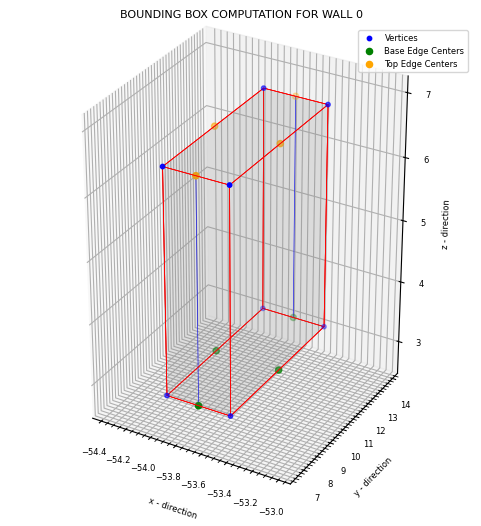

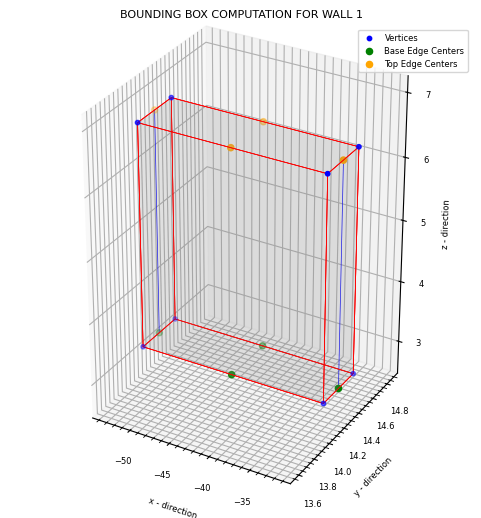

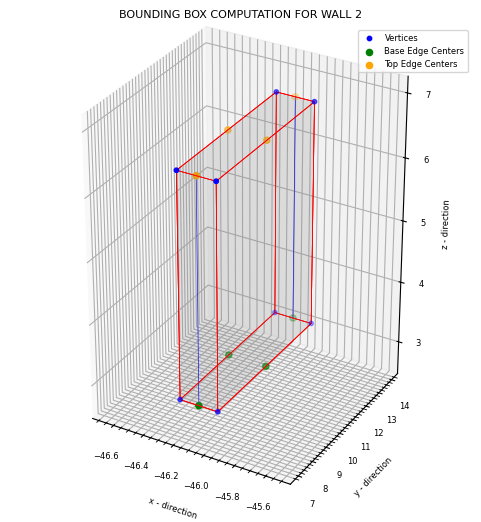

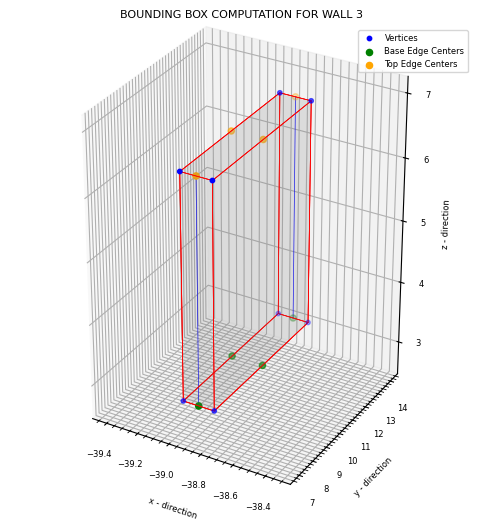

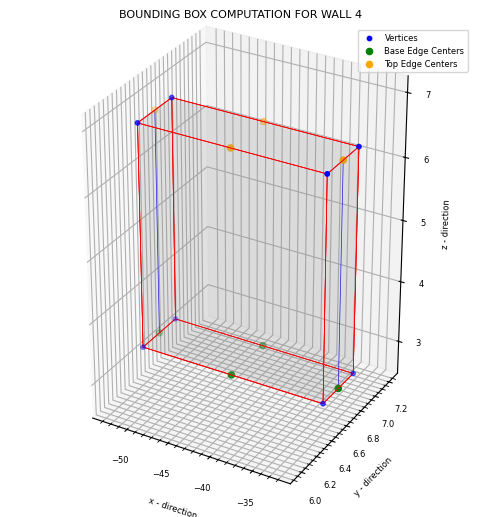

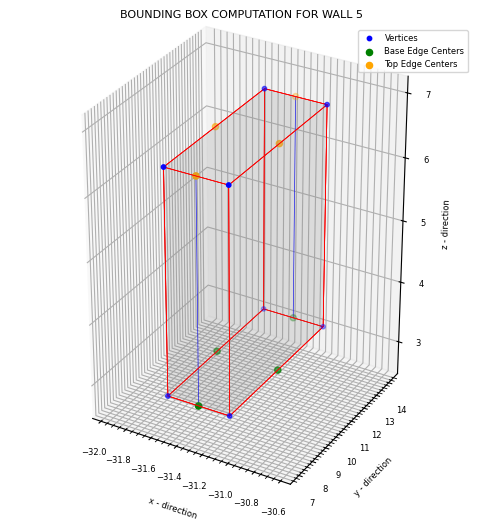

In [272]:
# def compute_features_bbox(base_vertices, top_vertices, wall_idx):
#     # Combine base and top vertices into a single array for easier plotting
#     vertices = np.vstack([base_vertices, top_vertices])

#     # Edges connecting the base, top, and vertical sides
#     edges = [
#         [base_vertices[0], base_vertices[1]], 
#         [base_vertices[1], base_vertices[2]],  
#         [base_vertices[2], base_vertices[3]],  
#         [base_vertices[3], base_vertices[0]],  
#         [top_vertices[0], top_vertices[1]],    
#         [top_vertices[1], top_vertices[2]],    
#         [top_vertices[2], top_vertices[3]],    
#         [top_vertices[3], top_vertices[0]],    
#         [base_vertices[0], top_vertices[0]],  
#         [base_vertices[1], top_vertices[1]],   
#         [base_vertices[2], top_vertices[2]],   
#         [base_vertices[3], top_vertices[3]]    
#     ]

#     # Faces of the 3D bounding box
#     faces = [
#         [base_vertices[0], base_vertices[1], base_vertices[2], base_vertices[3]],  
#         [top_vertices[0], top_vertices[1], top_vertices[2], top_vertices[3]], 
#         [base_vertices[0], top_vertices[0], top_vertices[1], base_vertices[1]],  
#         [base_vertices[1], top_vertices[1], top_vertices[2], base_vertices[2]], 
#         [base_vertices[2], top_vertices[2], top_vertices[3], base_vertices[3]],  
#         [base_vertices[3], top_vertices[3], top_vertices[0], base_vertices[0]]   
#     ]

#     # Base and Top edges
#     base_edges = [
#         [base_vertices[0], base_vertices[1]], 
#         [base_vertices[1], base_vertices[2]],  
#         [base_vertices[2], base_vertices[3]],  
#         [base_vertices[3], base_vertices[0]]  
#     ]
    
#     top_edges = [
#         [top_vertices[0], top_vertices[1]],    
#         [top_vertices[1], top_vertices[2]],    
#         [top_vertices[2], top_vertices[3]],    
#         [top_vertices[3], top_vertices[0]]    
#     ]
    
#     # Calculate center points of the base, top, and middle edges
#     base_edge_centers = [(edge[0] + edge[1]) / 2 for edge in base_edges]
#     top_edge_centers = [(edge[0] + edge[1]) / 2 for edge in top_edges]

#     # Determine which are the shorter edges based on length
#     edge_lengths = [np.linalg.norm(base_vertices[0] - base_vertices[1]), np.linalg.norm(base_vertices[1] - base_vertices[2])]
    
#     if edge_lengths[0] < edge_lengths[1]:
#         # Edge 0-1 and 2-3 are shorter
#         shorter_edges_indices = [0, 2]
#     else:
#         # Edge 1-2 and 3-0 are shorter
#         shorter_edges_indices = [1, 3]

#     # Connect the corresponding base and top center vertices of the shorter edges
#     shorter_internal_lines = [
#         [base_edge_centers[shorter_edges_indices[0]], top_edge_centers[shorter_edges_indices[0]]],
#         [base_edge_centers[shorter_edges_indices[1]], top_edge_centers[shorter_edges_indices[1]]]
#     ]

#     # Calculate lengths and thickness by connecting opposite center points
#     length_base = np.linalg.norm(base_edge_centers[0] - base_edge_centers[2])  # Opposite edges
#     thickness_base = np.linalg.norm(base_edge_centers[1] - base_edge_centers[3])  # Opposite edges
#     length_top = np.linalg.norm(top_edge_centers[0] - top_edge_centers[2])  # Opposite edges
#     thickness_top = np.linalg.norm(top_edge_centers[1] - top_edge_centers[3])  # Opposite edges
#     length_middle = np.linalg.norm(base_edge_centers[shorter_edges_indices[0]] - base_edge_centers[shorter_edges_indices[1]])  # Shorter edge length
#     thickness_middle = np.linalg.norm(top_edge_centers[shorter_edges_indices[0]] - top_edge_centers[shorter_edges_indices[1]])  # Shorter edge thickness

#     # Prepare results for output
#     result = {
#         'base vertices': base_vertices,
#         'base edges': base_edges,
#         'top_vertices': top_vertices,
#         'top edges': top_edges,
#         'base_centers': base_edge_centers,
#         'top_centers': top_edge_centers,
#         'middle_centers': None,  # Middle centers no longer used for lines
#         'shorter_internal_lines': shorter_internal_lines,  # Internal lines for shorter edges
#         'length_base': length_base,
#         'thickness_base': thickness_base,
#         'length_top': length_top,
#         'thickness_top': thickness_top,
#         'length_middle': length_middle,
#         'thickness_middle': thickness_middle
#     }

#     # Call the plot function
#     plot_bounding_box(vertices, edges, faces, base_edge_centers, top_edge_centers, shorter_internal_lines, wall_idx)

#     return result

# # Function to plot the bounding box, including internal lines and surfaces
# def plot_bounding_box(vertices, edges, faces, base_edge_centers, top_edge_centers, shorter_internal_lines, wall_idx):
#     fig = plt.figure(figsize=(6, 6))
#     ax = fig.add_subplot(111, projection='3d')

#     # Add faces of the bounding box
#     ax.add_collection3d(Poly3DCollection(faces, facecolors='grey', linewidths=0.50, edgecolors='r', alpha=.10))

#     # Plot the edges of the bounding box
#     for edge in edges:
#         ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], [edge[0][2], edge[1][2]], color='r', linewidth=0.50)

#     # Plot the internal lines between base and top edge centers (shorter edges only)
#     for line in shorter_internal_lines:
#         ax.plot(
#             [line[0][0], line[1][0]],  # X coordinates (base center to top center)
#             [line[0][1], line[1][1]],  # Y coordinates (base center to top center)
#             [line[0][2], line[1][2]],  # Z coordinates (base center to top center)
#             color='blue', linestyle='-', linewidth=0.5  # Blue solid lines for internal structure
#         )

#     # Plot the vertices as points
#     ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='blue', label='Vertices', s=10)

#     # Plot the centers of base and top edges
#     ax.scatter(np.array(base_edge_centers)[:, 0], np.array(base_edge_centers)[:, 1], np.array(base_edge_centers)[:, 2], 
#                color='green', label='Base Edge Centers', s=20)
#     ax.scatter(np.array(top_edge_centers)[:, 0], np.array(top_edge_centers)[:, 1], np.array(top_edge_centers)[:, 2], 
#                color='orange', label='Top Edge Centers', s=20)

#     # Set labels and title
#     ax.set_xlabel('x - direction', fontsize=6)
#     ax.set_ylabel('y - direction', fontsize=6)
#     ax.set_zlabel('z - direction', fontsize=6)
#     plt.title(f'BOUNDING BOX COMPUTATION FOR WALL {wall_idx}', fontsize=8)

#     # Customize grid and ticks
#     plt.minorticks_on()
#     plt.tick_params(which='major', labelsize=6)
#     plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
#     plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

#     # Compute the axis limits based on vertices to center the plot
#     x_limits = [np.min(vertices[:, 0]) - 0.50, np.max(vertices[:, 0]) + 0.50]
#     y_limits = [np.min(vertices[:, 1]) - 0.50, np.max(vertices[:, 1]) + 0.50]
#     z_limits = [np.min(vertices[:, 2]) - 0.50, np.max(vertices[:, 2]) + 0.50]

#     # Set the axis limits to center the bounding box in the plot
#     ax.set_xlim(x_limits)
#     ax.set_ylim(y_limits)
#     ax.set_zlim(z_limits)
    
#     # Show the plot
#     plt.legend(fontsize=6)
#     ax.set_box_aspect([1, 1, 1.5])  # Equal aspect ratio
#     plt.show()

# # Example: Loop over base and top vertices to compute and plot
# for i in range(len(base_vertices)):
#     compute_features_bbox(base_vertices[i], top_vertices[i], i)




In [79]:
# Assuming wall_coordinates, wall_oriented_bboxes, and walls_nodes are returned properly from bounding_boxes()
wall_coordinates, wall_oriented_bboxes, walls_nodes = bounding_boxes(wall_coordinates, walls_nodes)

# Loop through each set of wall points
for i, wall_points in enumerate(wall_coordinates):
    
    coordinates = wall_points[:, :3]
    print(f"Wall {i} coordinates:\n", coordinates)

    graph = Graph().parse(str(graph_path))
    nodes = tl.graph_to_nodes(graph)
    print (f'Graph {graph} nodes {nodes}')

    # ceilings_nodes = [n for n in nodes if 'ceilings' in n.subject.lower() and isinstance(n, PointCloudNode)]
    # floors_nodes = [n for n in nodes if 'floors' in n.subject.lower() and isinstance(n, PointCloudNode)]
    # levels_nodes = levels_bbox(floor_bboxes, ceiling_bboxes)

    rotated_box = rotate_points(bounding_box, center, rotation_matrix.T)
    rotated_points = rotate_points(points, center, rotation_matrix.T)
    print(f'Rotated box {rotated_box}\n Rotated_points{rotated_points}')

for i, wall_points in enumerate(wall_coordinates):
    width, depth, height_walls, center, rotation, min_z, max_z = compute_3d_features(laz, walls_nodes, coordinates, rotated_box, rotation_matrix, graph_path)
    print(f'Wall {i}: Width: {width}, Depth: {depth}, Height: {height_walls}, Location: {center}, Rotation: {rotation}')

    # # Write the computed wall properties to the output file
    # with open(output_file_path, 'a') as output_file:
    #     output_file.write(
    #         f'Wall {i}\n'
    #         f'Width: {width:.3f}\n'
    #         f'Depth: {depth:.3f}\n'
    #         f'Height: {height_walls:.3f}\n'
    #         f'Location: {center}\n'
    #         f'Rotation: {rotation:.2f}\n\n'
    #     )

    #     # Export to JSON
    #     json_export(output_folder, name, i, width, depth, height_walls, center, rotation)

    #     # Optional: Generate mesh of wall
    #     object_mesh(wall_points, min_z, max_z, height_walls, rotated_box, depth, width, output_folder, f"{name}_wall_{i}")

    #     # Plotting if enabled
    #     if plot:
    #         plt.figure(figsize=(8, 6))

    #         # Plot the wall points
    #         plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', markersize=0.5, label='Wall Points')

    #         # Plot the original bounding box (before adjustment)
    #         plt.plot(np.append(rotated_box[:, 0], rotated_box[0, 0]),
    #                  np.append(rotated_box[:, 1], rotated_box[0, 1]),
    #                  'g-', lw=2, label='Original Bounding Box')

    #         # Labels and formatting
    #         plt.xlabel('x')
    #         plt.ylabel('y')
    #         plt.title(f'Bounding Box Adjustments for Wall {i}')
    #         plt.legend()
    #         plt.grid(True)
    #         plt.axis('equal')
    #         plt.show()



Wall 0:
 - Oriented Bounding Box Center: [-53.67903488  10.23553314   4.86128383]
 - Plane Model: [-9.99905070e-01 -1.37786269e-02 -0.00000000e+00  5.35994002e+01]
 - 2D Normal: [-0.99990507 -0.01377863 -0.        ]
 - Wall Direction: inwards
Wall 1:
 - Oriented Bounding Box Center: [-42.44772918  14.16633023   4.85592631]
 - Plane Model: [ -0.01597947   0.99987232   0.         -14.94716764]
 - 2D Normal: [-0.01597947  0.99987232  0.        ]
 - Wall Direction: outwards
Wall 2:
 - Oriented Bounding Box Center: [-46.06352987  10.46287065   4.85449037]
 - Plane Model: [9.99893292e-01 1.46083958e-02 0.00000000e+00 4.58618096e+01]
 - 2D Normal: [0.99989329 0.0146084  0.        ]
 - Wall Direction: outwards
Wall 3:
 - Oriented Bounding Box Center: [-38.87050642  10.48043883   5.19972276]
 - Plane Model: [-9.99914770e-01 -1.30557326e-02 -0.00000000e+00  3.87901507e+01]
 - 2D Normal: [-0.99991477 -0.01305573 -0.        ]
 - Wall Direction: inwards
Wall 4:
 - Oriented Bounding Box Center: [-42

AttributeError: 'PointCloudNode' object has no attribute 'position'

In [43]:
for i, wall_points in enumerate(wall_coordinates):
    # Extract the 2D coordinates (first two columns)
    coordinates = wall_points[:, :2]

    # Compute the bounding box and rotation matrix for the coordinates
    bounding_box, rotation_matrix = compute_bounding_box(coordinates)
    center = np.mean(bounding_box, axis=0)

    # Rotate the bounding box and wall points around the center
    rotated_box = rotate_points(bounding_box, center, rotation_matrix.T)
    rotated_points = rotate_points(coordinates, center, rotation_matrix.T)

    # Extract the four corners of the rotated bounding box
    A, B, C, D = rotated_box[0], rotated_box[1], rotated_box[2], rotated_box[3]

    # Compute the new X coordinates using a custom function for best coverage
    new_x_coordinate, success = compute_best_coverage_segments(rotated_points, 0.010, 0, i)
    if not success:
        print(f'Wall {i}: Failed to compute X coverage, skipping.')
        continue

    # Compute the new Y coordinates using a custom function for best coverage
    new_y_coordinate, success = compute_best_coverage_segments(rotated_points, 0.010, 1, i)
    if not success:
        print(f'Wall {i}: Failed to compute Y coverage, skipping.')
        continue

    # Update bounding box points with new X and Y coordinates
    B[0], C[0], A[0], D[0] = new_x_coordinate
    B[1], A[1], C[1], D[1] = new_y_coordinate

    # Store the updated points in an array
    new_points = np.array([A, B, C, D])
    print(f'Wall {i}, New points: {new_points}')

    # Compute 3D features of the wall, such as width, depth, height, etc.
    width, depth, height, center, rotation, min_z, max_z = compute_3d_features(
        wall_points, new_points, rotation_matrix, min_z=0, max_z=5
    )
    print(f'Wall {i}: Width: {width}, Depth: {depth}, Height: {height}, Location: {center}, Rotation: {rotation}')

    # Write the computed wall properties to the output file
    with open(output_file_path, 'a') as output_file:
        output_file.write(
                f'Wall {i}\n'
                f'Width: {width:.3f}\n'
                f'Depth: {depth:.3f}\n'
                f'Height: {height:.3f}\n'
                f'Location: {center}\n'
                f'Rotation: {rotation}\n\n'
        )

    # Export the wall information to JSON
    json_export(output_folder, name, i, width, depth, height, center, rotation)

    # Optional: Generate and save a mesh representation of the wall
    object_mesh(wall_points, min_z, max_z, height, new_points, depth, width, output_folder, f"{name}_wall_{i}")

Wall 0: Failed to compute X coverage, skipping.
Wall 1: Failed to compute X coverage, skipping.
Wall 2: Failed to compute X coverage, skipping.
Wall 3: Failed to compute X coverage, skipping.
Wall 4: Failed to compute X coverage, skipping.
Wall 5: Failed to compute X coverage, skipping.


In [ ]:
def compute_wall_thickness(wall_points, wall_normals, wall_dominant_normal, t_distance, t_thickness):
    """
    Compute the thickness of a singular wall based on its point cloud data and normals.
    
    Parameters:
    - wall_points: np.array of shape (N, 3) representing the 3D coordinates of the wall's points.
    - wall_normals: np.array of shape (N, 3) representing the normals associated with each point.
    - wall_dominant_normal: np.array of shape (3,) representing the dominant normal of the wall's plane.
    - t_distance: float, the radius distance for neighbor search.
    - t_thickness: float, the minimum allowed wall thickness.
    
    Returns:
    - wall_thickness: float, the estimated thickness of the wall.
    """
    # Create a KDTree for nearest-neighbor searches
    pcd_tree = o3d.geometry.KDTreeFlann(o3d.geometry.PointCloud(o3d.utility.Vector3dVector(wall_points)))

    # Estimate normals if they are not provided
    if wall_normals is None:
        print("Estimating normals...")
        wall_normals = np.asarray(o3d.geometry.PointCloud(o3d.utility.Vector3dVector(wall_points)).estimate_normals())
    
    # Select every 100th point and its normal to reduce computational load
    points = wall_points[::100]
    normals = wall_normals[::100]

    # Filter points whose normals closely align with the wall's dominant normal
    idx = np.where(np.abs(np.einsum('i,ji->j', wall_dominant_normal, normals)) > 0.9)
    points = points[idx]
    normals = normals[idx]

    distances = []

    # For each selected point and its normal
    for p, q in zip(points, normals):
        # Find all points within a radius of t_distance around the point p
        [k, idx, _] = pcd_tree.search_radius_vector_3d(p, t_distance)
        if k == 0:  # No neighbors found, skip
            continue
        
        # Filter neighbors whose normals are within 0.9 radians of the point's normal
        kNormals = wall_normals[idx]
        aligned_indices = np.where(np.abs(np.einsum('i,ji->j', q, kNormals)) > 0.9)
        filtered_idx = np.array(idx)[aligned_indices]

        # Compute the orthogonal distances between the point and the nearby points
        vectors = p - wall_points[filtered_idx]
        orthogonal_distances = np.abs(np.einsum('i,ji->j', q, vectors))

        # Store the maximum orthogonal distance
        distances.append(orthogonal_distances.max())

    # Calculate the 90th percentile of the distances to estimate the wall thickness
    if distances:
        distance = np.percentile(np.sort(np.array(distances)), 90)
        wall_thickness = max(distance, t_thickness)  # Enforce minimum thickness
    else:
        wall_thickness = t_thickness  # No valid distances, fall back to minimum thickness

    return wall_thickness


t_distance = 1.0  # Example radius for neighbor search
t_thickness = 0.1  # Minimum wall thickness

# Compute wall thickness
wall_thickness = compute_wall_thickness(wall_points, wall_normals, wall_dominant_normal, t_distance, t_thickness)
print(f"Computed wall thickness: {wall_thickness}")

In [24]:
def compute_plane_from_points(p1, p2, p3):
    """Compute plane coefficients (a, b, c, d) from 3 non-collinear points."""
    # Vectors in the plane
    v1 = p2 - p1
    v2 = p3 - p1

    # Plane normal (a, b, c)
    normal = np.cross(v1, v2)
    a, b, c = normal

    # Plane offset (d)
    d = -np.dot(normal, p1)

    return a, b, c, d

def distance_from_plane(point, plane):
    """Compute distance from a point to the plane."""
    a, b, c, d = plane
    x, y, z = point
    return abs(a*x + b*y + c*z + d) / np.sqrt(a**2 + b**2 + c**2)

def ransac_inliers_normals(points, distance_threshold=0.03, num_iterations=500, min_inliers=0.8):
    best_planes = None
    best_inliers = []
    
    num_points = points.shape[0]
    target_inliers_count = int(min_inliers * num_points)

    for i in range(num_iterations):
        # Randomly select 3 points to define a plane
        sample_indices = np.random.choice(num_points, 3, replace=False)
        p1, p2, p3 = points[sample_indices]

        # Compute the plane from the 3 points
        plane = compute_plane_from_points(p1, p2, p3)

        if len(plane) < 4:
            raise ValueError("The plane returned from RANSAC does not have the expected format.")
        
        # Extract the normal vector from the plane model
        normal = np.array(plane[:3])
        normal[2] = 0  # Project to 2D (zero out the z-component)
        normal /= np.linalg.norm(normal)  # Normalize the normal vector
        
        # Vectorized distance calculation for all points
        distances = np.abs(np.dot(points - p1, plane[:3]) + plane[3]) / np.linalg.norm(plane[:3])

        # Get inliers that satisfy the distance threshold
        inliers = np.array(np.where(distances < distance_threshold)[0])

        # If this plane has more inliers, save it
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_planes = plane

            # Early stopping if the number of inliers is sufficient
            if len(inliers) > target_inliers_count:
                break

    return best_planes, best_inliers, normal

def adjust_face_center(inlier_points):
    # Calculate the min and max z values
    min_z = np.min(inlier_points[:, 2])
    max_z = np.max(inlier_points[:, 2])
    height = max_z - min_z

    # Calculate the mean (center) of the inlier points
    face_center = np.mean(inlier_points, axis=0)
    
    # Adjust the z-coordinate based on height (if needed)
    face_center[2] = height / 2

    return face_center

def compute_nearest_neighbors(query_points, data_points, n_neighbors = 3):

    # Initialize NearestNeighbors with the number of neighbors
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(data_points)
    
    # Find the nearest neighbors
    distances, indices = nbrs.kneighbors(query_points)
    
    return indices, distances

def create_sections(points, min_z, max_z):
    # Assuming `create_sections` is defined elsewhere and returns appropriate values
    # Here, just placeholder values are returned
    base_section = {"z_min": min_z, "points": points[points[:, 2] == min_z].tolist()}
    top_section = {"z_max": max_z, "points": points[points[:, 2] == max_z].tolist()}
    base_center = {"z": min_z, "coordinates": np.mean(points[points[:, 2] == min_z], axis=0).tolist()}
    top_center = {"z": max_z, "coordinates": np.mean(points[points[:, 2] == max_z], axis=0).tolist()}
    z_axes = {"start": base_center["coordinates"], "end": top_center["coordinates"]}
    angle_degrees = 0  # Placeholder for angle calculation

    return base_section, top_section, base_center, top_center, z_axes, angle_degrees

def define_bbox_axis(bbox_center, extent_x, extent_y, extent_z):

    # Determine the bounding box extents
    bbox_extents = np.array([extent_x, extent_y, extent_z])
    
    # Define the midpoints of the bounding box along each principal direction
    midpoints = {
        'x': bbox_center + np.array([extent_x, 0, 0]),
        'y': bbox_center + np.array([0, extent_y, 0]),
        'z': bbox_center + np.array([0, 0, extent_z])
    }
    
    # This example assumes you want the axis along the z-direction
    axis_origin = bbox_center - np.array([0, 0, extent_z])
    axis_end = bbox_center + np.array([0, 0, extent_z])
    
    # Define the axis direction vector
    axis_direction = axis_end - axis_origin
    
    return axis_origin, axis_direction

def convert_ndarray_to_list(ndarray):
    """Convert a NumPy array to a list."""
    if isinstance(ndarray, np.ndarray):
        return ndarray.tolist()
    return ndarray

def clean_data(data):
    """Ensure all non-serializable data types are converted to JSON-compatible types."""
    if isinstance(data, dict):
        return {k: clean_data(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_data(item) for item in data]
    elif isinstance(data, np.ndarray):
        return convert_ndarray_to_list(data)
    else:
        return data
    
def compute_normal(start_point, end_point):

    direction = np.array(end_point) - np.array(start_point)
    normal = np.array([-direction[1], direction[0], 0])

    normalized_normal = normal / np.linalg.norm(normal)
    
    return normal, normalized_normal

def compute_plane_direction(normal_vector):
    # Unit vector along the z-axis
    z_axis = np.array([0, 0, 1])
    
    # Normalize the normal vector
    normal_vector = normal_vector / np.linalg.norm(normal_vector)
    
    # Compute the angle between the normal vector and the z-axis
    dot_product = np.dot(normal_vector, z_axis)
    angle_with_z = np.arccos(dot_product)  # This gives the angle in radians

    # Convert radians to degrees for better interpretability
    angle_with_z_degrees = np.degrees(angle_with_z)
    
    print(f'Angle between the normal vector and the z-axis: {angle_with_z_degrees:.2f} degrees')

    return angle_with_z_degrees

def rewrite_bbox_with_new_z(obb_vertices, adjusted_min_z, adjusted_max_z):

    updated_vertices = np.copy(obb_vertices)  # Copy the original vertices to avoid modifying them directly

    # Iterate through the vertices and replace the Z-values
    
    for i, vertex in enumerate(updated_vertices):
        # If the Z-value is close to the original min_z, replace with adjusted_min_z
        if np.isclose(vertex[2], np.min(obb_vertices[:, 2]), atol=1e-6):
            updated_vertices[i][2] = adjusted_min_z

        # If the Z-value is close to the original max_z, replace with adjusted_max_z
        elif np.isclose(vertex[2], np.max(obb_vertices[:, 2]), atol=1e-6):
            updated_vertices[i][2] = adjusted_max_z

    return updated_vertices

WALLS

In [64]:
z_threshold = 0.15

In [65]:
def wall_points(laz, graph_path):

    graph = Graph().parse(str(graph_path))
    nodes = tl.graph_to_nodes(graph)

    # Filter wall nodes
    walls_nodes = [wall for wall in nodes if 'walls' in wall.subject.lower() and isinstance(wall, PointCloudNode)]
    #print(f'Wall nodes: {walls_nodes}\nNumber of wall nodes: {len(walls_nodes)}')
    print(f'wall nodes: {len(walls_nodes)}')

    coordinates = []

    for wall in walls_nodes:
        
        idx = np.where((laz.classes == wall.class_id) & (laz.objects == wall.object_id))

        if idx is not None and len(idx[0]) > 0:  # Ensure valid and non-empty indices
            coord_x = laz.x[idx]
            coord_y = laz.y[idx]
            coord_z = laz.z[idx]

            coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
            coordinates.append(coordinates_)  

            #print(f'Coordinates for Wall {wall.object_id}: Number of points {coordinates_.shape[0]}')
        #else:
            #print(f"No points found for Wall {wall.object_id}")

    return coordinates, walls_nodes


In [66]:
output_folder = path /'outputs' 
output_json_file = os.path.join(output_folder, 'walls_json.json')


In [75]:
def compute_obb(points):
    # Ensure that there are enough points to compute OBB
    if len(points) < 3:
        raise ValueError("Not enough points to compute OBB.")

    obb_center = np.mean(points, axis=0)

    pca = PCA(n_components=3)
    pca.fit(points - obb_center)
    rotation_matrix = pca.components_

    # Ensure rotation matrix is valid (determinant should be +1)
    if np.linalg.det(rotation_matrix) < 0:
        rotation_matrix[2, :] = -rotation_matrix[2, :]

    points_projected = np.dot(points - obb_center, rotation_matrix.T)
    min_proj = np.min(points_projected, axis=0)
    max_proj = np.max(points_projected, axis=0)

    obb_extent = (max_proj - min_proj) / 2.0

    local_axes = rotation_matrix.T
    obb_vertices = []
    for dx in [-1, 1]:
        for dy in [-1, 1]:
            for dz in [-1, 1]:
                vertex_offset = (
                    dx * obb_extent[0] * local_axes[:, 0] +
                    dy * obb_extent[1] * local_axes[:, 1] +
                    dz * obb_extent[2] * local_axes[:, 2]
                )
                vertex = obb_center + vertex_offset
                obb_vertices.append(vertex)

    return obb_center, obb_extent, obb_vertices, rotation_matrix


def bbox_topology(floor_bboxes, ceiling_bboxes, obb_extent, obb_vertices_list, rotation_matrix, coordinates, z_threshold):
    # Ensure coordinates is a valid 2D array of (N, 3)
    coordinates = np.array(coordinates)
    if coordinates.ndim != 2 or coordinates.shape[1] != 3:
        raise ValueError(f"Expected `coordinates` to be a 2D array of shape (N, 3), but got shape {coordinates.shape}")

    # Convert OBB vertices to a numpy array
    obb_vertices = np.array(obb_vertices_list)

    # Extract z-coordinates from the OBB vertices
    z_coords_obb = obb_vertices[:, 2]
    min_z_vertex = np.min(z_coords_obb)
    max_z_vertex = np.max(z_coords_obb)

    # Handle empty floor or ceiling bounding boxes
    if floor_bboxes.size == 0:
        print("Warning: Floor bounding boxes are empty. Using min Z from OBB.")
        z_floor_min = min_z_vertex  # Use min Z from OBB if floor_bboxes is empty
    else:
        # Convert floor bboxes to a numpy array and get min Z
        floor_bboxes = np.array(floor_bboxes)
        z_floor_min = np.min(floor_bboxes[:, :, 2])

    if ceiling_bboxes.size == 0:
        print("Warning: Ceiling bounding boxes are empty. Using max Z from OBB.")
        z_ceiling_max = max_z_vertex  # Use max Z from OBB if ceiling_bboxes is empty
    else:
        # Convert ceiling bboxes to a numpy array and get max Z
        ceiling_bboxes = np.array(ceiling_bboxes)
        z_ceiling_max = np.max(ceiling_bboxes[:, :, 2])

    # Adjust min_z and max_z based on floor and ceiling if within z_threshold
    adjusted_min_z = z_floor_min if abs(min_z_vertex - z_floor_min) < z_threshold else min_z_vertex
    adjusted_max_z = z_ceiling_max if abs(max_z_vertex - z_ceiling_max) < z_threshold else max_z_vertex

    # Compute the center z-coordinate and extents
    center_z = (adjusted_max_z + adjusted_min_z) / 2.0
    extent_x, extent_y, extent_z = obb_extent

    # Calculate bounding box characteristics
    center_x, center_y, _ = np.mean(coordinates, axis=0)
    length = max(extent_x, extent_y)
    thickness = min(extent_x, extent_y)

    # Compute half extents
    half_extent_x = extent_x / 2
    half_extent_y = extent_y / 2

    bbox_center = np.array([center_x, center_y, center_z])
    extents = np.array([extent_x, extent_y, extent_z])

    # Determine the main axis and set the start and end points for base, middle, and top sections
    if extent_x > extent_y:
        start_point_base = (center_x - half_extent_x, center_y, adjusted_min_z)
        end_point_base = (center_x + half_extent_x, center_y, adjusted_min_z)
        start_point_middle = (center_x - half_extent_x, center_y, center_z)
        end_point_middle = (center_x + half_extent_x, center_y, center_z)
        start_point_top = (center_x - half_extent_x, center_y, adjusted_max_z)
        end_point_top = (center_x + half_extent_x, center_y, adjusted_max_z)
    else:
        start_point_base = (center_x, center_y - half_extent_y, adjusted_min_z)
        end_point_base = (center_x, center_y + half_extent_y, adjusted_min_z)
        start_point_middle = (center_x, center_y - half_extent_y, center_z)
        end_point_middle = (center_x, center_y + half_extent_y, center_z)
        start_point_top = (center_x, center_y - half_extent_y, adjusted_max_z)
        end_point_top = (center_x, center_y + half_extent_y, adjusted_max_z)

    # Return the computed values
    return (bbox_center, start_point_middle, end_point_middle, start_point_base, end_point_base,
            start_point_top, end_point_top, length, thickness, extents, extent_x, extent_y, extent_z,
            obb_extent, adjusted_min_z, adjusted_max_z, rotation_matrix)


def process_wall(wall_data, floor_bboxes, ceiling_bboxes, z_threshold):
    try:
        class_id, object_id, coordinates_ = wall_data
    except ValueError as e:
        raise ValueError(f"Expected wall_data to contain three elements (class_id, object_id, coordinates_), but got: {wall_data}") from e

    wall_metadata = []

    if len(coordinates_) > 3:
        # Compute the OBB (Oriented Bounding Box) for the wall
        obb_center, obb_extent, obb_vertices_list, rotation_matrix = compute_obb(coordinates_)

        # Compute the bounding box topology
        bbox_topology_data = bbox_topology(
            floor_bboxes, ceiling_bboxes, obb_extent, obb_vertices_list, 
            rotation_matrix, coordinates_, z_threshold
        )

        (bbox_center, start_point_middle, end_point_middle, start_point_base, end_point_base,
         start_point_top, end_point_top, length, thickness, extents, extent_x, extent_y, extent_z, 
         obb_extent, adjusted_min_z, adjusted_max_z, rotation_matrix) = bbox_topology_data

        # Create the wall metadata dictionary
        wall_data = {
            'object_id': object_id,
            'class_id': class_id,
            'min_z': float(adjusted_min_z),
            'max_z': float(adjusted_max_z),
            'height': float(adjusted_max_z - adjusted_min_z),
            'start_point_base': [float(x) for x in start_point_base],
            'end_point_base': [float(x) for x in end_point_base],
            'start_point_middle': [float(x) for x in start_point_middle],
            'end_point_middle': [float(x) for x in end_point_middle],
            'start_point_top': [float(x) for x in start_point_top],
            'end_point_top': [float(x) for x in end_point_top],
            'length': float(length),
            'thickness': float(thickness),
            'normal': rotation_matrix[:, 2].tolist(),
            'z_axes': rotation_matrix[:, 2].tolist(),
            'angle_degrees': float(np.rad2deg(np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])))
        }

        wall_metadata.append(wall_data)

    return wall_metadata


def export_walls_topology(wall_metadata, output_json_file):
    json_data = {
        "filename": os.path.basename(output_json_file),
        "objects": wall_metadata
    }

    try:
        with open(output_json_file, "w") as json_file:
            json.dump(json_data, json_file, indent=4)
        print(f"JSON data written to file: {output_json_file}")
    except IOError as e:
        print(f"Error writing to file {output_json_file}: {e}")


def process_and_export_walls(laz, z_threshold, output_json_file, num_workers=None):
    coordinates = wall_points(laz)
    
    wall_metadata = []

    # Use ThreadPoolExecutor or ProcessPoolExecutor for parallel processing
    if num_workers is None:
        num_workers = multiprocessing.cpu_count()

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_wall, wall_data, z_threshold) for wall_data in coordinates]
        for future in futures:
            try:
                wall_metadata.extend(future.result())
            except Exception as e:
                print(f"Error in processing wall data: {e}")
    
    export_walls_topology(wall_metadata, output_json_file)


def create_topological_model(bbox_center, obb_extents, adjusted_min_z, adjusted_max_z):
    # Define the extents in x, y, and z directions
    extent_x, extent_y, extent_z = obb_extents

    # Compute the 4 base vertices (bottom face of the bounding box)
    base_vertices = np.array([
        [bbox_center[0] - extent_x, bbox_center[1] - extent_y, adjusted_min_z],  # Vertex 0 (bottom-left)
        [bbox_center[0] + extent_x, bbox_center[1] - extent_y, adjusted_min_z],  # Vertex 1 (bottom-right)
        [bbox_center[0] + extent_x, bbox_center[1] + extent_y, adjusted_min_z],  # Vertex 2 (top-right)
        [bbox_center[0] - extent_x, bbox_center[1] + extent_y, adjusted_min_z]   # Vertex 3 (top-left)
    ])

    # Calculate the top vertices
    top_vertices = np.array([
        [bbox_center[0] - extent_x, bbox_center[1] - extent_y, adjusted_max_z],  # Vertex 4 (top-bottom-left)
        [bbox_center[0] + extent_x, bbox_center[1] - extent_y, adjusted_max_z],  # Vertex 5 (top-bottom-right)
        [bbox_center[0] + extent_x, bbox_center[1] + extent_y, adjusted_max_z],  # Vertex 6 (top-top-right)
        [bbox_center[0] - extent_x, bbox_center[1] + extent_y, adjusted_max_z]   # Vertex 7 (top-top-left)
    ])

    # Combine base and top vertices
    vertices = np.vstack((base_vertices, top_vertices))

    # Define faces of the box (each face is defined by 4 vertices)
    faces = [
        [0, 1, 2, 3],  # Base face
        [4, 5, 6, 7],  # Top face
        [0, 1, 5, 4],  # Side face 1 (between base and top)
        [1, 2, 6, 5],  # Side face 2
        [2, 3, 7, 6],  # Side face 3
        [3, 0, 4, 7]   # Side face 4
    ]

    return vertices, faces


def export_obj_file(vertices, faces, obj_file_path):
    try:
        with open(obj_file_path, 'w') as obj_file:
            # Write vertices
            for vertex in vertices:
                obj_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
            
            # Write faces (OBJ indexing starts at 1, not 0)
            for face in faces:
                obj_file.write(f"f {face[0] + 1} {face[1] + 1} {face[2] + 1} {face[3] + 1}\n")
        print(f"OBJ file written to: {obj_file_path}")
    except IOError as e:
        print(f"Error writing OBJ file: {e}")
    with open(obj_file_path, 'w') as obj_file:
        # Write vertices
        for vertex in vertices:
            obj_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
        
        # Write faces (OBJ indexing starts at 1, not 0)
        for face in faces:
            obj_file.write(f"f {face[0] + 1} {face[1] + 1} {face[2] + 1} {face[3] + 1}\n")

In [83]:
wall_coordinates, walls_nodes = wall_points(laz, graph_path)

wall_metadata = []  # Create an empty list to store wall metadata

# Create an empty list to store all vertices and faces for the OBJ file
all_vertices = []
all_faces = []
vertex_offset = 0  # Used to offset face indices correctly

# Loop through each wall node
for idx, wall in enumerate(walls_nodes):
    # Extract coordinates for the current wall
    coordinates_ = wall_coordinates[idx]
    
    # Create the tuple containing wall data (class_id, object_id, coordinates_)
    wall_data = (wall.class_id, wall.object_id, coordinates_)
    
    # Process the wall and compute its metadata (using floor and ceiling bounding boxes)
    wall_metadata_ = process_wall(wall_data, floor_bboxes, ceiling_bboxes, z_threshold)

    # Append the processed wall metadata to the overall list
    wall_metadata.extend(wall_metadata_)

    # Compute the Oriented Bounding Box (OBB) for the current wall
    obb_center, obb_extent, obb_vertices, rotation_matrix = compute_obb(coordinates_)

    # Call bbox_topology to compute topology-related values for the wall
    (bbox_center, start_point_middle, end_point_middle, 
     start_point_base, end_point_base, start_point_top, end_point_top, 
     length, thickness, extents, extent_x, extent_y, extent_z, obb_extent, 
     adjusted_min_z, adjusted_max_z, rotation_matrix) = bbox_topology(
        floor_bboxes, ceiling_bboxes, obb_extent, obb_vertices, 
        rotation_matrix, coordinates_, z_threshold
    )

    # Print wall details
    wall_idx = np.where((laz.classes == wall.class_id) & (laz.objects == wall.object_id))
    print(f'wall {wall_idx} bbox {obb_extent}\n Length {length}\n Thickness {thickness}')

    # Collect the vertices for the surfaces
    vertices = [
        list(start_point_base),
        list(end_point_base),
        list(start_point_top),
        list(end_point_top)
    ]

    # Adjust vertex indices for the faces
    base_face = [vertex_offset, vertex_offset + 1, vertex_offset + 3, vertex_offset + 2]  # Rectangle face (vertical surface)
    top_face = [vertex_offset + 2, vertex_offset + 3]  # Top line (horizontal)
    bottom_face = [vertex_offset, vertex_offset + 1]  # Bottom line (horizontal)
    
    # Append these vertices and faces to the global list
    all_vertices.extend(vertices)
    all_faces.append(base_face)
    
    # Optionally, append top and bottom surfaces as faces (if needed)
    # all_faces.append(top_face)
    # all_faces.append(bottom_face)

    # Update the vertex offset for the next wall
    vertex_offset += len(vertices)

path_out = Path(os.getcwd()).parents[0]
output_folder = path_out /'outputs' 
print(output_folder)
output_json_file = os.path.join(output_folder, 'walls_json.json')
output_obj_file = os.path.join(output_folder, '1', f'{name}_walls.obj')
export_walls_topology(wall_metadata, output_json_file)
export_obj_file(np.array(all_vertices), all_faces, output_obj_file)


wall nodes: 6
wall (array([1436897, 1436898, 1436899, ..., 1657723, 1657724, 1657725],
      dtype=int64),) bbox [3.67106767 2.12483161 0.26076956]
 Length 3.6710676740896897
 Thickness 2.12483161208818
wall (array([1657726, 1657727, 1657728, ..., 2173284, 2173285, 2173286],
      dtype=int64),) bbox [11.37181738  1.81272094  0.21424692]
 Length 11.37181737791241
 Thickness 1.812720943853531
wall (array([2173287, 2173288, 2173289, ..., 2299458, 2299459, 2299460],
      dtype=int64),) bbox [3.35773172 1.80519526 0.12480713]
 Length 3.3577317196374867
 Thickness 1.8051952600497656
wall (array([2299461, 2299462, 2299463, ..., 2422727, 2422728, 2422729],
      dtype=int64),) bbox [3.4497929  1.49540503 0.11861897]
 Length 3.449792899561703
 Thickness 1.4954050341112204
wall (array([2422730, 2422731, 2422732, ..., 2780793, 2780794, 2780795],
      dtype=int64),) bbox [10.84981062  1.93532896  0.29577438]
 Length 10.849810619700534
 Thickness 1.9353289569082865
wall (array([2780796, 2780797,

In [82]:
def create_topological_model(bbox_center, obb_extents, adjusted_min_z, adjusted_max_z):
    
    vertices = []
    edges = []
    faces = []
    
    # Define the extents in x, y, and z directions
    extent_x, extent_y, extent_z = obb_extents

    # Compute the 4 base vertices (bottom face of the bounding box)
    base_z = bbox_center[2] - extent_z  # Bottom z-coordinate

    # Calculate the base vertices
    base_vertices = np.array([
        [bbox_center[0] - extent_x, bbox_center[1] - extent_y, adjusted_min_z],  # Vertex 0 (bottom-left)
        [bbox_center[0] + extent_x, bbox_center[1] - extent_y, adjusted_min_z],  # Vertex 1 (bottom-right)
        [bbox_center[0] + extent_x, bbox_center[1] + extent_y, adjusted_min_z],  # Vertex 2 (top-right)
        [bbox_center[0] - extent_x, bbox_center[1] + extent_y, adjusted_min_z]   # Vertex 3 (top-left)
    ])

    # Calculate the top vertices
    top_z = bbox_center[2] + extent_z  # Top z-coordinate

    top_vertices = np.array([
        [bbox_center[0] - extent_x, bbox_center[1] - extent_y, adjusted_max_z],  # Vertex 4 (top-bottom-left)
        [bbox_center[0] + extent_x, bbox_center[1] - extent_y, adjusted_max_z],  # Vertex 5 (top-bottom-right)
        [bbox_center[0] + extent_x, bbox_center[1] + extent_y, adjusted_max_z],  # Vertex 6 (top-top-right)
        [bbox_center[0] - extent_x, bbox_center[1] + extent_y, adjusted_max_z]   # Vertex 7 (top-top-left)
    ])

    # Stack base and top vertices into a single array
    vertices = np.vstack((base_vertices, top_vertices))

    # Define the edges of the box (base, top, and vertical edges)
    base_edges = np.array([[0, 1], [1, 2], [2, 3], [3, 0]])  # Base edges
    top_edges = np.array([[4, 5], [5, 6], [6, 7], [7, 4]])   # Top edges
    vertical_edges = np.array([[0, 4], [1, 5], [2, 6], [3, 7]])  # Vertical edges connecting base and top

    # Stack all edges together
    edges = np.vstack((base_edges, top_edges, vertical_edges))

    # Define faces of the box (each face is defined by 4 vertices)
    faces = [
        [0, 1, 2, 3],  # Base face
        [4, 5, 6, 7],  # Top face
        [0, 1, 5, 4],  # Side face 1 (between base and top)
        [1, 2, 6, 5],  # Side face 2
        [2, 3, 7, 6],  # Side face 3
        [3, 0, 4, 7]   # Side face 4
    ]

    return vertices, edges, faces


In [80]:
def export_to_obj(vertices, faces, file_path):
    with open(file_path, 'w') as obj_file:
        # Write vertices
        for v in vertices:
            obj_file.write(f'v {v[0]:.3f} {v[1]:.3f} {v[2]:.3f}\n')

        # Write faces
        for face in faces:
            face_str = ' '.join([str(v) for v in face])
            obj_file.write(f'f {face_str}\n')

    print(f"OBJ file exported to {file_path}")

In [83]:
for idx, wall in enumerate(walls_nodes):

    vertices, edges, faces = create_topological_model(bbox_center, obb_extents, adjusted_min_z, adjusted_max_z)
    
    output_obj_file = os.path.join(output_folder, '1', 'walls.obj')
    vertices, edges, faces = create_topological_model(bbox_center, obb_extents, adjusted_min_z, adjusted_max_z)
    export_to_obj(vertices, faces, output_obj_file)

OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
O

In [ ]:
# def create_topological_model(bbox, bbox_center, start_point_middle, end_point_middle, start_point_base, end_point_base, start_point_top, end_point_top, 
#                              thickness, obb_extents, adjusted_min_z, adjusted_max_z):

OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj


In [64]:
import numpy as np

def export_wall_to_obj(minimum_bounding_box, floor_z, ceiling_z, file_name):
    """
    This function generates vertices, edges, and faces for a wall, 
    and exports them in the OBJ file format.
    
    Args:
        minimum_bounding_box (list): A list of 4 points representing the wall's base bounding box.
        floor_z (float): The z-coordinate of the wall's base (floor level).
        ceiling_z (float): The z-coordinate of the wall's top (ceiling level).
        file_name (str): The path to the OBJ file to save.
    """
    
    # Define the base and top vertices using minimum bounding box points
    base_vertices = [
        [minimum_bounding_box[0][0], minimum_bounding_box[0][1], floor_z], 
        [minimum_bounding_box[1][0], minimum_bounding_box[1][1], floor_z], 
        [minimum_bounding_box[2][0], minimum_bounding_box[2][1], floor_z],
        [minimum_bounding_box[3][0], minimum_bounding_box[3][1], floor_z]
    ]
    
    end_vertices = [
        [minimum_bounding_box[0][0], minimum_bounding_box[0][1], ceiling_z], 
        [minimum_bounding_box[1][0], minimum_bounding_box[1][1], ceiling_z], 
        [minimum_bounding_box[2][0], minimum_bounding_box[2][1], ceiling_z],
        [minimum_bounding_box[3][0], minimum_bounding_box[3][1], ceiling_z]
    ]

    # Stack base and top vertices
    base_vertices = np.array(base_vertices)
    end_vertices = np.array(end_vertices)
    vertices = np.vstack((base_vertices, end_vertices))

    # Create vertex arrays for base and top
    A0, B0, C0, D0 = base_vertices
    A1, B1, C1, D1 = end_vertices

    # Define the edges of the wall
    base_edges = np.array([[A0, B0], [B0, C0], [C0, D0], [D0, A0]])
    top_edges = np.array([[A1, B1], [B1, C1], [C1, D1], [D1, A1]])
    vertical_edges = np.array([[A0, A1], [B0, B1], [C0, C1], [D0, D1]])

    # Compute faces
    faces = [
        [3, 7, 8],  # Face 1
        [3, 8, 4],  # Face 2
        [1, 5, 6],  # Face 3
        [1, 6, 2],  # Face 4
        [7, 3, 2],  # Face 5
        [7, 2, 6],  # Face 6
        [4, 8, 5],  # Face 7
        [4, 5, 1],  # Face 8
        [8, 7, 6],  # Face 9
        [8, 6, 5],  # Face 10
        [3, 4, 1],  # Face 11
        [3, 1, 2]   # Face 12
    ]

    # Write the OBJ file
    with open(file_name, "w") as f:
        # Write vertices
        for v in vertices:
            f.write(f'v {v[0]:.3f} {v[1]:.3f} {v[2]:.3f}\n')

        # Write faces
        for face in faces:
            face_str = ' '.join([str(v) for v in face])
            f.write(f'f {face_str}\n')
    
    print(f"OBJ file generated successfully at {file_name}")


# Loop through walls and export each one as a separate OBJ file
for idx, wall_metadata in enumerate(walls_nodes):
    if wall_metadata is Ellipsis or wall_metadata is None:
        print(f"Skipping wall {idx + 1} due to invalid data.")
        continue  # Skip invalid entries

    try:
        # Access values as dictionary
        minimum_bounding_box = [
            wall_metadata['start_point_base'],  # Point A (bottom-left)
            wall_metadata['end_point_base'],    # Point B (bottom-right)
            wall_metadata['end_point_middle'],  # Point C (top-right)
            wall_metadata['start_point_middle'] # Point D (top-left)
        ]

        floor_z = wall_metadata['min_z']
        ceiling_z = wall_metadata['max_z']

        # Generate a unique file name for each wall
        file_name = f'wall_{idx + 1}_output.obj'

        # Call the function to export the wall model to an OBJ file
        export_wall_to_obj(minimum_bounding_box, floor_z, ceiling_z, file_name)
    
    except (AttributeError, KeyError) as e:
        print(f"Error processing wall {idx + 1}: {e}")


    # Call the function to export the wall model to an OBJ file
    export_wall_to_obj(minimum_bounding_box, floor_z, ceiling_z, file_name)



Skipping wall 1 due to invalid data.


In [31]:
# for idx, wall in enumerate(walls_nodes):
#     output_obj_file = os.path.join(output_folder, '1', 'walls.obj')
#     export_to_obj(all_vertices, all_faces, output_obj_file)

OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
OBJ file exported to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\1\walls.obj
O

In [199]:
#  # Get the coordinates for the current wall
# wall_coordinates, _ = wall_points(laz, graph_path)  # Only get coordinates for the current wall

# for idx, wall in enumerate(walls_nodes):
#     # Get the index of the points belonging to the current wall
#     point_idx = np.where((laz.classes == wall.class_id) & (laz.objects == wall.object_id))



In [47]:
output_folder = path /'outputs' 
output_obj_file = os.path.join(output_folder,  'walls_obj')

In [54]:
def create_topological_model(wall_metadata):

    vertices = []
    edges = []
    faces = []
    
    vertex_index_map = {}  # To avoid duplicate vertices

    def get_or_add_vertex(vertex):
        """ Helper function to get the index of a vertex or add it if not present. """
        vertex_tuple = tuple(vertex)
        if vertex_tuple in vertex_index_map:
            return vertex_index_map[vertex_tuple]
        else:
            vertex_idx = len(vertices) + 1  # 1-based indexing
            vertices.append(vertex_tuple)
            vertex_index_map[vertex_tuple] = vertex_idx
            return vertex_idx

    # Loop through all walls in wall_metadata
    for wall in wall_metadata:
        if wall is None:
            continue

        object_id = wall.get('object_id')

        base_i_vertex = wall.get('start_point_base')
        base_j_vertex = wall.get('end_point_base')
        top_i_vertex = wall.get('start_point_top')
        top_j_vertex = wall.get('end_point_top')

        # Debugging: Print the vertex coordinates
        print(f"Wall {object_id}: Base vertices: {base_i_vertex}, {base_j_vertex}, Top vertices: {top_i_vertex}, {top_j_vertex}")

        # Skip if any essential points are missing
        if not (base_i_vertex and base_j_vertex and top_i_vertex and top_j_vertex):
            print(f"Skipping wall due to missing essential points: {wall}")
            continue

        # Get or add vertices and their indices
        base_i_idx = get_or_add_vertex(base_i_vertex)
        base_j_idx = get_or_add_vertex(base_j_vertex)
        top_i_idx = get_or_add_vertex(top_i_vertex)
        top_j_idx = get_or_add_vertex(top_j_vertex)

        # Define edges (avoiding duplicates)
        new_edges = [
            (base_i_idx, base_j_idx),
            (base_j_idx, top_j_idx),
            (top_j_idx, top_i_idx),
            (top_i_idx, base_i_idx)
        ]
        for edge in new_edges:
            if edge not in edges and tuple(reversed(edge)) not in edges:  # Avoid duplicates
                edges.append(edge)

        # Define faces (avoiding duplicates)
        new_faces = [
            [base_i_idx, base_j_idx, top_j_idx, top_i_idx],  # Top face
            # Add more faces if needed, ensuring no duplicates
        ]
        for face in new_faces:
            if face not in faces and list(reversed(face)) not in faces:  # Avoid duplicates
                faces.append(face)

        print(f'Wall {object_id}: Added vertices {base_i_idx}, {base_j_idx}, {top_i_idx}, {top_j_idx}')
        print(f'Edges: {edges[-4:]}')  # Print the last 4 edges added
        print(f'Faces: {faces[-1]}')   # Print the last face added

    return vertices, edges, faces


# Now process all walls together
vertices, edges, faces = create_topological_model(walls_metadata)

print(f"Processed all walls with vertices: {vertices}, edges: {edges}, faces: {faces}")




Wall 2000: Base vertices: (-5.5745633886161565, 14.360314856732167, -4.939237992733474), (20.31207846405646, 14.360314856732167, -4.939237992733474), Top vertices: (-5.5745633886161565, 14.360314856732167, 8.035309998117054), (20.31207846405646, 14.360314856732167, 8.035309998117054)
Wall 2000: Added vertices 1, 2, 3, 4
Edges: [(1, 2), (2, 4), (4, 3), (3, 1)]
Faces: [1, 2, 4, 3]
Wall 2001: Base vertices: (-5.5745633886161565, 14.360314856732167, -4.939237992733474), (20.31207846405646, 14.360314856732167, -4.939237992733474), Top vertices: (-5.5745633886161565, 14.360314856732167, 8.035309998117054), (20.31207846405646, 14.360314856732167, 8.035309998117054)
Wall 2001: Added vertices 1, 2, 3, 4
Edges: [(1, 2), (2, 4), (4, 3), (3, 1)]
Faces: [1, 2, 4, 3]
Wall 2002: Base vertices: (-5.5745633886161565, 14.360314856732167, -4.939237992733474), (20.31207846405646, 14.360314856732167, -4.939237992733474), Top vertices: (-5.5745633886161565, 14.360314856732167, 8.035309998117054), (20.312078

In [49]:
# for wall in walls_metadata:
#     if wall is None:
#         continue
    
#     # Process each wall individually
#     vertices, edges, faces = create_topological_model([wall])  # Pass a list with a single wall

#     # Optionally, print or do something with the resulting vertices, edges, and faces
#     print(f"Processed wall with vertices: {vertices}, edges: {edges}, faces: {faces}")


Wall 2000: Base vertices: (-5.5745633886161565, 14.360314856732167, -4.939237992733474), (20.31207846405646, 14.360314856732167, -4.939237992733474), Top vertices: (-5.5745633886161565, 14.360314856732167, 8.035309998117054), (20.31207846405646, 14.360314856732167, 8.035309998117054)
Wall 2000: Added vertices 1, 2, 3, 4
Edges: [(1, 2), (2, 4), (4, 3), (3, 1)]
Faces: [1, 2, 4, 3]
Processed wall with vertices: [(-5.5745633886161565, 14.360314856732167, -4.939237992733474), (20.31207846405646, 14.360314856732167, -4.939237992733474), (-5.5745633886161565, 14.360314856732167, 8.035309998117054), (20.31207846405646, 14.360314856732167, 8.035309998117054)], edges: [(1, 2), (2, 4), (4, 3), (3, 1)], faces: [[1, 2, 4, 3]]
Wall 2001: Base vertices: (-5.5745633886161565, 14.360314856732167, -4.939237992733474), (20.31207846405646, 14.360314856732167, -4.939237992733474), Top vertices: (-5.5745633886161565, 14.360314856732167, 8.035309998117054), (20.31207846405646, 14.360314856732167, 8.035309998

In [51]:
output_folder = 'c:\\Users\\oscar\\OneDrive - Fondazione Bruno Kessler\\KUL_GeometricModel\\outputs'
output_obj_file = os.path.join(output_folder, 'walls.obj')  # Ensure it's a file

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def write_obj_file(vertices, faces, output_file):

    with open(output_file, 'w') as obj_file:
        # Write vertices to the file in OBJ format
        for vertex in vertices:
            obj_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
        
        # Write faces to the file in OBJ format
        for face in faces:
            # Face indices in OBJ format are 1-based
            obj_file.write(f"f {' '.join(str(index) for index in face)}\n")
    
    print(f"OBJ file successfully written to {output_file}")




In [52]:
for wall in walls_metadata:
    if wall is None:
        continue

    write_obj_file(vertices, faces, output_obj_file)

OBJ file successfully written to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\walls.obj
OBJ file successfully written to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\walls.obj
OBJ file successfully written to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\walls.obj
OBJ file successfully written to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\walls.obj
OBJ file successfully written to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\walls.obj
OBJ file successfully written to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\walls.obj
OBJ file successfully written to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\walls.obj
OBJ file successfully written to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\walls.obj
OBJ file successfully written to

ASSOCIATE Z VALUES - WATER TANK MODEL

In [29]:
def extract_z_levels(floor_bboxes, ceiling_bboxes):
    # Convert the NumPy arrays to lists for easy manipulation
    floor_bboxes_list = list(floor_bboxes)
    ceiling_bboxes_list = list(ceiling_bboxes)

    # Concatenate the lists of floor and ceiling bounding boxes
    levels_bboxes = floor_bboxes_list + ceiling_bboxes_list

    z_min_values = []
    z_max_values = []
    
    # Extract z_min and z_max from each bounding box (assuming list or tuple structure)
    for bbox in levels_bboxes:
        # Assuming z_min is the first element and z_max is the second element
        z_min = bbox[0]  # Access the z_min value by index
        z_max = bbox[1]  # Access the z_max value by index
        z_min_values.append(z_min)
        z_max_values.append(z_max)
        print(f'Bounding Box z_min: {z_min}, z_max: {z_max}')
    
    return levels_bboxes, z_min_values, z_max_values


In [30]:
levels_bboxes, z_min_values, z_max_values = extract_z_levels(floor_bboxes, ceiling_bboxes)
print(type(level_bboxes))

Bounding Box z_min: [-10.57  -0.15  -0.05], z_max: [25.3  -0.15 -0.05]
Bounding Box z_min: [-10.56  -0.15   2.67], z_max: [25.31 -0.15  2.67]
<class 'numpy.ndarray'>


WATERTANK COMPLEX CELL MODEL (WCCM)

In [45]:
z_threshold = 0.15
t_intersection=0.5
t_orthogonal=0.5

def compute_normal(start_point, end_point):
    """Compute the normal vector to the wall plane given start and end points."""
    direction = np.array(end_point) - np.array(start_point)
    normal = np.array([-direction[1], direction[0], 0])  # 2D normal vector for the wall
    normalized_normal = normal / np.linalg.norm(normal)
    return normal, normalized_normal

def extract_z_levels(floor_bboxes, ceiling_bboxes):
    """Extract z_min and z_max values from floor and ceiling bounding boxes."""
    z_min_values = [bbox[2][2] for bbox in floor_bboxes]
    z_max_values = [bbox[6][2] for bbox in ceiling_bboxes]
    return z_min_values, z_max_values

def find_closest_level(z_value, z_values, threshold):
    """Find the closest level to a given z_value within a threshold."""
    for i, z in enumerate(z_values):
        if abs(z_value - z) < threshold:
            return i, z
    return None, None

def intersect_line_2d(start1, end1, start2, end2, strict=True):
    """Find intersection point of two lines in 2D."""
    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

    A, B, C, D = start1, end1, start2, end2
    return (ccw(A, C, D) != ccw(B, C, D)) and (ccw(A, B, C) != ccw(A, B, D))

def get_oriented_bounding_box(start_point, end_point, normal, thickness, height):
    """
    Generates an oriented bounding box for a wall based on its axis, normal, thickness, and height.

    Args:
        start_point (np.ndarray): The starting point of the wall (base of the wall).
        end_point (np.ndarray): The ending point of the wall (base of the wall).
        normal (np.ndarray): The outward normal vector of the wall.
        thickness (float): The thickness of the wall.
        height (float): The height of the wall.

    Returns:
        o3d.geometry.OrientedBoundingBox: The oriented bounding box representing the 3D wall geometry.
    """
    # Calculate the direction of the wall axis (normalized)
    direction = (end_point - start_point) / np.linalg.norm(end_point - start_point)

    # Compute the outward normal in the XY plane if not already normalized
    outward_normal = np.cross(direction, np.array([0, 0, 1]))

    # Ensure the normal is normalized
    outward_normal = outward_normal / np.linalg.norm(outward_normal)

    # Create the 4 base corner points of the wall (before adding height)
    base_points = [
        start_point + outward_normal * thickness / 2,  # Top-left base
        start_point - outward_normal * thickness / 2,  # Bottom-left base
        end_point + outward_normal * thickness / 2,    # Top-right base
        end_point - outward_normal * thickness / 2     # Bottom-right base
    ]

    # Add height to each of the base points to create the upper corners
    upper_points = [p + np.array([0, 0, height]) for p in base_points]

    # Combine base and upper points to form a complete set of 8 points
    all_points = np.array(base_points + upper_points)

    # Create a point cloud from the wall points
    pcd = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(all_points))

    # Generate the oriented bounding box from the point cloud
    oriented_bbox = pcd.get_oriented_bounding_box()

    return oriented_bbox

In [47]:
def walls_topology(walls_data, floor_bboxes, ceiling_bboxes, laz, t_intersection, t_orthogonal):
    for wall_data in walls_data:
        
        wall_metadata = process_wall_data(laz, wall_data)
                
        if wall_metadata is None:
            continue

        z_min_wall = float(wall_metadata['min_z'])
        z_max_wall = float(wall_metadata['max_z'])
        height_wall = float(wall_metadata['height'])
       
        start_point_base = np.array(wall_metadata['start_point_base'])
        end_point_base = np.array(wall_metadata['end_point_base'])
        length = np.linalg.norm(end_point_base - start_point_base)
        print(f'Wall {wall_metadata["object_id"]} length {length} height: {height_wall}')

        # Compute normal
        normal, normalized_normal = compute_normal(start_point_base, end_point_base)
        wall_thickness = float(wall_metadata['thickness'])

        # Get the oriented bounding box for the wall
        oriented_bbox = get_oriented_bounding_box(start_point_base, end_point_base, normal, wall_thickness, height_wall)
        
        # Create the TriangleMesh for the wall
        n_wall = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(oriented_bbox)
        
        # Create the LineSet for the wall bounding box
        wallBox = o3d.geometry.LineSet.create_from_oriented_bounding_box(oriented_bbox)
        wallBox.paint_uniform_color([0, 0, 1])  # Blue for the wall box

        # Add the wall and bounding box to metadata
        wall_metadata['wall'] = n_wall
        wall_metadata['wallBox'] = wallBox

        print(f'name: {wall_metadata["object_id"]}, wall: {n_wall}')



In [48]:
walls_topology(walls_data, floor_bboxes, ceiling_bboxes, laz, t_intersection, t_orthogonal)

Bbox 2000 bbox data OrientedBoundingBox: center: (7.34006, 29.7952, 1.39886), extent: 36.062, 2.84578, 0.399006)
center_x: 7.3400601100103335, center_y: 29.795179499997445, center_z: 1.3988647526874243 extent_x: 36.061988191820504, extent_y: 2.845782683828042, extent_z: 0.39900573078472074
Length of the bounding box: 36.061988191820504 Thickness of the bounding box: 0.39900573078472074
Sign: 1.0
Axis Origin: [ 7.34006011 29.7951795   0.99985902] Axis Direction [0.         0.         0.79801146]
Index wall: 2000
Start point middle: (-10.690933985899918, 29.795179499997445, 1.3988647526874243)
End point middle: (25.371054205920586, 29.795179499997445, 1.3988647526874243)
Start point base: (-10.690933985899918, 29.795179499997445, 0.0)
End point base: (25.371054205920586, 29.795179499997445, 0.0)
Start point top: (-10.690933985899918, 29.795179499997445, 2.82)
End point top: (25.371054205920586, 29.795179499997445, 2.82)
Base center: {'z': 0.0, 'coordinates': [-9.162799999999999, 29.64320

In [33]:
def walls_topology(walls_data, floor_bboxes, ceiling_bboxes, laz, t_intersection, t_orthogonal):
    
    for wall_data in walls_data:
        
        wall_metadata = process_wall_data(laz, wall_data)
                
        if wall_metadata is None:
            continue

        z_min_wall = float(wall_metadata['min_z'])
        z_max_wall = float(wall_metadata['max_z'])
        height_wall = float(wall_metadata['height'])
       
        start_point_base = np.array(wall_metadata['start_point_base'])
        end_point_base = np.array(wall_metadata['end_point_base'])
        length = np.linalg.norm(end_point_base - start_point_base)
        print(f'Wall {wall_metadata["object_id"]} length {length} height: {height_wall}')

        # Compute orthogonal curves
        normal, normalized_normal = compute_normal(start_point_base, end_point_base)
        wall_thickness = float(wall_metadata['thickness'])
        orthogonal_startpoint = start_point_base + normal * wall_thickness / 2
        orthogonal_endpoint = end_point_base + normal * wall_thickness / 2

        # Extract z values from levels
        z_min_values, z_max_values = extract_z_levels(floor_bboxes, ceiling_bboxes)

        # Find closest levels for z_min and z_max
        min_level_idx, min_z_level = find_closest_level(z_min_wall, z_min_values, z_threshold)
        max_level_idx, max_z_level = find_closest_level(z_max_wall, z_max_values, z_threshold)

        # Print closest floor and ceiling levels
        if min_level_idx is not None:
            print(f'Wall {wall_metadata["object_id"]} is close to floor level {min_level_idx} with z_min {min_z_level}')
        if max_level_idx is not None:
            print(f'Wall {wall_metadata["object_id"]} is close to ceiling level {max_level_idx} with z_max {max_z_level}')

        # Compute intersections with nearby walls
        axisPoints = np.array([start_point_base, end_point_base])
        axisPointsOrthogonal = np.array([orthogonal_startpoint, orthogonal_endpoint])

        # Create a list of resources excluding the current wall
        resources = [w['resource'] for w in walls_data if w['object_id'] != wall_metadata['object_id']]
        print("Number of resources:", len(resources))

        if resources:
            # Assuming gmu.create_identity_point_cloud returns a PointCloud object
            referencePcd, identityArray = gmu.create_identity_point_cloud(resources)
            reference_points = np.asarray(referencePcd.points)

            # Compute nearest neighbors
            idx, distances = gmu.compute_nearest_neighbors(axisPoints, reference_points, n=10)
            idx = idx[np.where(distances < t_intersection)]
            points = np.asarray(referencePcd.points)[idx]
            indices = identityArray[idx]
            nearby_walls = [walls_data[i] for i in indices]
            print(f'Found {len(nearby_walls)} nearby walls for {wall_metadata["object_id"]}')

            # Process intersections with nearby walls
            for w in nearby_walls:
                w_metadata = process_wall_data(laz, w)
                if w_metadata is None:
                    continue

                w_start_point = np.array(w_metadata['start_point_base'])
                w_end_point = np.array(w_metadata['end_point_base'])
                w_orthogonal_startpoint = w_start_point + normal * wall_thickness / 2
                w_orthogonal_endpoint = w_end_point + normal * wall_thickness / 2

                # Check intersection between wall axes
                intersection_point = intersect_line_2d(start_point_base, end_point_base, w_start_point, w_end_point)
                if intersection_point is not None:
                    d = distance.euclidean(np.ravel(intersection_point), np.ravel(start_point_base))
                    if d < t_intersection:
                        print(f'Intersection between {wall_metadata["object_id"]} and {w_metadata["object_id"]} at {intersection_point}, distance: {d}')

                # Check intersection between orthogonal curves
                orthogonal_intersection_point = intersect_line_2d(orthogonal_startpoint, orthogonal_endpoint, w_orthogonal_startpoint, w_orthogonal_endpoint)
                if orthogonal_intersection_point is not None:
                    d = distance.euclidean(np.ravel(orthogonal_intersection_point), np.ravel(orthogonal_startpoint))
                    if d < t_orthogonal:
                        print(f'Orthogonal intersection between {wall_metadata["object_id"]} and {w_metadata["object_id"]} at {orthogonal_intersection_point}, distance: {d}')

        # Process wall nodes into a point cloud and mesh
        point_list = []

        points = np.array([start_point_base, end_point_base])
        point_list.extend(points + normal * wall_thickness / 2)  # Positive side
        point_list.extend(points - normal * wall_thickness / 2)  # Negative side
        point_list.extend(np.array(point_list) + np.array([0, 0, height_wall]))  # Add height dimension

        # Convert points into a PointCloud and create bounding box
        pcd = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(point_list))
        box = pcd.get_oriented_bounding_box()
        
        # Create TriangleMesh for the wall and a LineSet for the bounding box
        n_wall = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(box)
        wallBox = o3d.geometry.LineSet.create_from_oriented_bounding_box(box)
        wallBox.paint_uniform_color([0, 0, 1])

        # Add the wall and bounding box to metadata
        wall_metadata['wall'] = n_wall
        wall_metadata['wallBox'] = wallBox

        print(f'name: {wall_metadata["object_id"]}, wall: {n_wall}')

In [34]:
walls_topology(walls_data, floor_bboxes, ceiling_bboxes, laz, t_intersection, t_orthogonal)

Bbox 2000 bbox data OrientedBoundingBox: center: (7.34006, 29.7952, 1.39886), extent: 36.062, 2.84578, 0.399006)
center_x: 7.3400601100103335, center_y: 29.795179499997445, center_z: 1.3988647526874243 extent_x: 36.061988191820504, extent_y: 2.845782683828042, extent_z: 0.39900573078472074
Length of the bounding box: 36.061988191820504 Thickness of the bounding box: 0.39900573078472074
Sign: 1.0
Axis Origin: [ 7.34006011 29.7951795   0.99985902] Axis Direction [0.         0.         0.79801146]
Index wall: 2000
Start point middle: (-10.690933985899918, 29.795179499997445, 1.3988647526874243)
End point middle: (25.371054205920586, 29.795179499997445, 1.3988647526874243)
Start point base: (-10.690933985899918, 29.795179499997445, 0.0)
End point base: (25.371054205920586, 29.795179499997445, 0.0)
Start point top: (-10.690933985899918, 29.795179499997445, 2.82)
End point top: (25.371054205920586, 29.795179499997445, 2.82)
Base center: {'z': 0.0, 'coordinates': [-9.162799999999999, 29.64320

C:\Users\oscar\AppData\Local\Temp\ipykernel_42140\771915339.py:43: RuntimeWarning: invalid value encountered in divide
  normal /= np.linalg.norm(normal)  # Normalize the normal vector


Bbox 2007 bbox data OrientedBoundingBox: center: (-4.20409, 1.21331, 1.37023), extent: 3.02533, 2.87072, 0.358692)
center_x: -4.204092295, center_y: 1.213308165, center_z: 1.370228705 extent_x: 3.0253313970110423, extent_y: 2.8707239315155233, extent_z: 0.3586919190412798
Length of the bounding box: 3.0253313970110423 Thickness of the bounding box: 0.3586919190412798
Sign: -1.0
Axis Origin: [-4.20409229  1.21330816  1.01153679] Axis Direction [0.         0.         0.71738384]
Index wall: 2007
Start point middle: (-5.716757993505521, 1.213308165, 1.370228705)
End point middle: (-2.6914265964944786, 1.213308165, 1.370228705)
Start point base: (-5.716757993505521, 1.213308165, 0.0)
End point base: (-2.6914265964944786, 1.213308165, 0.0)
Start point top: (-5.716757993505521, 1.213308165, 2.74)
End point top: (-2.6914265964944786, 1.213308165, 2.74)
Base center: {'z': 0.0, 'coordinates': [-4.296875, 1.3737500000000002, 0.0]}
Top center: {'z': 2.74, 'coordinates': [-4.12, -0.090000000000000

C:\Users\oscar\AppData\Local\Temp\ipykernel_42140\771915339.py:43: RuntimeWarning: invalid value encountered in divide
  normal /= np.linalg.norm(normal)  # Normalize the normal vector


Bbox 2018 bbox data OrientedBoundingBox: center: (19.9888, 8.67125, 1.41594), extent: 4.24057, 4.00601, 0.464656)
center_x: 19.988810514989016, center_y: 8.671254796303494, center_z: 1.415943304919633 extent_x: 4.240569425212742, extent_y: 4.006014294775675, extent_z: 0.4646562691086718
Length of the bounding box: 4.240569425212742 Thickness of the bounding box: 0.4646562691086718
Sign: 1.0
Axis Origin: [19.98881051  8.6712548   0.95128704] Axis Direction [0.         0.         0.92931254]
Index wall: 2018
Start point middle: (17.868525802382646, 8.671254796303494, 1.415943304919633)
End point middle: (22.109095227595386, 8.671254796303494, 1.415943304919633)
Start point base: (17.868525802382646, 8.671254796303494, 0.05)
End point base: (22.109095227595386, 8.671254796303494, 0.05)
Start point top: (17.868525802382646, 8.671254796303494, 2.89)
End point top: (22.109095227595386, 8.671254796303494, 2.89)
Base center: {'z': 0.05, 'coordinates': [20.94, 8.56, 0.05]}
Top center: {'z': 2.8

C:\Users\oscar\AppData\Local\Temp\ipykernel_42140\771915339.py:43: RuntimeWarning: invalid value encountered in divide
  normal /= np.linalg.norm(normal)  # Normalize the normal vector


Found 0 nearby walls for 2019
name: 2019, wall: TriangleMesh with 8 points and 12 triangles.
Bbox 2020 bbox data OrientedBoundingBox: center: (20.9645, 13.2439, 1.40203), extent: 2.87092, 1.64317, 0.470242)
center_x: 20.964530530278136, center_y: 13.243936756734072, center_z: 1.4020287650354162 extent_x: 2.8709244958897995, extent_y: 1.6431702993825903, extent_z: 0.47024199566394664
Length of the bounding box: 2.8709244958897995 Thickness of the bounding box: 0.47024199566394664
Sign: -1.0
Axis Origin: [20.96453053 13.24393676  0.93178677] Axis Direction [0.         0.         0.94048399]
Index wall: 2020
Start point middle: (19.529068282333235, 13.243936756734072, 1.4020287650354162)
End point middle: (22.399992778223037, 13.243936756734072, 1.4020287650354162)
Start point base: (19.529068282333235, 13.243936756734072, -0.03)
End point base: (22.399992778223037, 13.243936756734072, -0.03)
Start point top: (19.529068282333235, 13.243936756734072, 2.7800000000000002)
End point top: (22.

C:\Users\oscar\AppData\Local\Temp\ipykernel_42140\771915339.py:43: RuntimeWarning: invalid value encountered in divide
  normal /= np.linalg.norm(normal)  # Normalize the normal vector


Bbox 2038 bbox data OrientedBoundingBox: center: (0.715298, 11.6762, 1.39155), extent: 3.32169, 3.02088, 0.432595)
center_x: 0.7152981728785982, center_y: 11.676216847422326, center_z: 1.3915463456248363 extent_x: 3.321693401689027, extent_y: 3.0208804995059646, extent_z: 0.4325949624467612
Length of the bounding box: 3.321693401689027 Thickness of the bounding box: 0.4325949624467612
Sign: 1.0
Axis Origin: [ 0.71529817 11.67621685  0.95895138] Axis Direction [0.         0.         0.86518992]
Index wall: 2038
Start point middle: (-0.9455485279659154, 11.676216847422326, 1.3915463456248363)
End point middle: (2.3761448737231117, 11.676216847422326, 1.3915463456248363)
Start point base: (-0.9455485279659154, 11.676216847422326, 0.01)
End point base: (2.3761448737231117, 11.676216847422326, 0.01)
Start point top: (-0.9455485279659154, 11.676216847422326, 2.77)
End point top: (2.3761448737231117, 11.676216847422326, 2.77)
Base center: {'z': 0.01, 'coordinates': [-0.20863636363636362, 11.5

C:\Users\oscar\AppData\Local\Temp\ipykernel_42140\771915339.py:43: RuntimeWarning: invalid value encountered in divide
  normal /= np.linalg.norm(normal)  # Normalize the normal vector


Bbox 2038 bbox data OrientedBoundingBox: center: (0.715298, 11.6762, 1.39155), extent: 3.32169, 3.02088, 0.432595)
center_x: 0.7152981728785982, center_y: 11.676216847422326, center_z: 1.3915463456248363 extent_x: 3.321693401689027, extent_y: 3.0208804995059646, extent_z: 0.4325949624467612
Length of the bounding box: 3.321693401689027 Thickness of the bounding box: 0.4325949624467612
Sign: 1.0
Axis Origin: [ 0.71529817 11.67621685  0.95895138] Axis Direction [0.         0.         0.86518992]
Index wall: 2038
Start point middle: (-0.9455485279659154, 11.676216847422326, 1.3915463456248363)
End point middle: (2.3761448737231117, 11.676216847422326, 1.3915463456248363)
Start point base: (-0.9455485279659154, 11.676216847422326, 0.01)
End point base: (2.3761448737231117, 11.676216847422326, 0.01)
Start point top: (-0.9455485279659154, 11.676216847422326, 2.77)
End point top: (2.3761448737231117, 11.676216847422326, 2.77)
Base center: {'z': 0.01, 'coordinates': [-0.20863636363636362, 11.5

C:\Users\oscar\AppData\Local\Temp\ipykernel_42140\771915339.py:43: RuntimeWarning: invalid value encountered in divide
  normal /= np.linalg.norm(normal)  # Normalize the normal vector


Bbox 2024 bbox data OrientedBoundingBox: center: (12.8887, 14.6666, 1.42657), extent: 10.9518, 2.94377, 0.416715)
center_x: 12.888714533425022, center_y: 14.666594994930295, center_z: 1.4265734332093618 extent_x: 10.951753575171653, extent_y: 2.943771006857098, extent_z: 0.41671489440903653
Length of the bounding box: 10.951753575171653 Thickness of the bounding box: 0.41671489440903653
Sign: 1.0
Axis Origin: [12.88871453 14.66659499  1.00985854] Axis Direction [0.         0.         0.83342979]
Index wall: 2024
Start point middle: (7.412837745839195, 14.666594994930295, 1.4265734332093618)
End point middle: (18.36459132101085, 14.666594994930295, 1.4265734332093618)
Start point base: (7.412837745839195, 14.666594994930295, 0.03)
End point base: (18.36459132101085, 14.666594994930295, 0.03)
Start point top: (7.412837745839195, 14.666594994930295, 2.82)
End point top: (18.36459132101085, 14.666594994930295, 2.82)
Base center: {'z': 0.03, 'coordinates': [8.98, 14.76, 0.03]}
Top center: {

EXPORT WALLS TOPOLOGY: JSON AND OBJ

In [49]:
def export_walls_topology(wall_metadata, output_json_file):
    json_data = {
        "filename": ut.get_filename(output_json_file),
        "objects": []
    }

    for wall in wall_metadata:
        if wall is None:
            continue  # Skip if wall is None

        # Ensure all required keys are present in the wall data
        object_id = wall.get('object_id')
        min_z = wall.get('min_z')
        max_z = wall.get('max_z')
        height = wall.get('height')

        # If any essential field is missing, skip this wall
        if object_id is None or min_z is None or max_z is None or height is None:
            print(f"Skipping wall due to missing essential fields: {wall}")
            continue

        # Create the JSON object for each wall, handling missing optional fields safely
        json_dta = {
            'object_id': object_id,
            'wall min_z': float(min_z),
            'wall max_z': float(max_z),
            'wall height': float(height),
            'lower level': wall.get('min_level_idx', None),  # Use get() for optional fields
            'upper level': wall.get('max_level_idx', None),
            'start_base_point': wall.get('start_point_base'),
            'end_base_point': wall.get('end_point_base'),
            'start_middle_point': wall.get('start_point_middle'),
            'end_middle_point': wall.get('end_point_middle'),
            'start_top_point': wall.get('start_point_top'),
            'end_top_point': wall.get('end_point_top'),
            'wall length': wall.get('length'),
            'wall thickness': wall.get('thickness'),
            'normal vector': wall.get('normal'),
            'wall z axes': wall.get('z_axes'),
            'angle_degrees': wall.get('angle_degrees')
        }

        # Append the created JSON object to the main data
        json_data["objects"].append(json_dta)

    # Write this information to the JSON file
    with open(output_json_file, "w") as json_file:
        json.dump(json_data, json_file, indent=4)

    print(f"JSON data written to file: {output_json_file}")export_walls_topology(wall_metadata, output_json_file)

In [50]:
export_walls_topology(wall_metadata, output_json_file)

JSON data written to file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\32_ShortOffice_05_F1_small1_elements.json


CREATE MESHES FOR ELEMENTS

In [51]:
output_folder = path /'outputs' 
output_obj_file = os.path.join(output_folder,  'walls_obj')
vertices, edges, faces = create_topological_model(wall_metadata)

In [52]:
def create_topological_model(wall_metadata):

    vertices = []
    edges = []
    faces = []

    for wall in wall_metadata:
        if wall is None:
            continue

        object_id = wall.get('object_id')

        base_i_vertex = wall.get('start_point_base')
        base_j_vertex = wall.get('end_point_base')
        top_i_vertex = wall.get('start_point_top')
        top_j_vertex = wall.get('end_point_top')

        # Skip if any essential points are missing
        if not (base_i_vertex and base_j_vertex and top_i_vertex and top_j_vertex):
            print(f"Skipping wall due to missing essential points: {wall}")
            continue

        # Convert points to vertices
        start_base = tuple(base_i_vertex)
        end_base = tuple(base_j_vertex)
        start_top = tuple(top_i_vertex)
        end_top = tuple(top_j_vertex)

        # Define indices for new vertices
        base_i_idx = len(vertices) + 1
        vertices.append(start_base)
        base_j_idx = len(vertices) + 1
        vertices.append(end_base)
        top_i_idx = len(vertices) + 1
        vertices.append(start_top)
        top_j_idx = len(vertices) + 1
        vertices.append(end_top)

        # Define edges
        edges.append((base_i_idx, base_j_idx))
        edges.append((base_j_idx, top_j_idx))
        edges.append((top_j_idx, top_i_idx))
        edges.append((top_i_idx, base_i_idx))

        # Define faces (avoid duplicates)
        new_faces = [
            [base_i_idx, base_j_idx, top_j_idx, top_i_idx],  # Top face
            # Add more faces if needed, ensuring no duplicates
        ]

        for face in new_faces:
            if face not in faces:
                faces.append(face)

        print(f'Wall {object_id}: Added vertices {base_i_idx}, {base_j_idx}, {top_i_idx}, {top_j_idx}')
        print(f'Edges: {edges}')
        print(f'Faces: {faces}')

    return vertices, edges, faces


In [53]:
vertices, edges, faces = create_topological_model(wall_metadata)

Wall 2002: Added vertices 1, 2, 3, 4
Edges: [(1, 2), (2, 4), (4, 3), (3, 1)]
Faces: [[1, 2, 4, 3]]
Wall 2004: Added vertices 5, 6, 7, 8
Edges: [(1, 2), (2, 4), (4, 3), (3, 1), (5, 6), (6, 8), (8, 7), (7, 5)]
Faces: [[1, 2, 4, 3], [5, 6, 8, 7]]
Wall 2007: Added vertices 9, 10, 11, 12
Edges: [(1, 2), (2, 4), (4, 3), (3, 1), (5, 6), (6, 8), (8, 7), (7, 5), (9, 10), (10, 12), (12, 11), (11, 9)]
Faces: [[1, 2, 4, 3], [5, 6, 8, 7], [9, 10, 12, 11]]
Wall 2008: Added vertices 13, 14, 15, 16
Edges: [(1, 2), (2, 4), (4, 3), (3, 1), (5, 6), (6, 8), (8, 7), (7, 5), (9, 10), (10, 12), (12, 11), (11, 9), (13, 14), (14, 16), (16, 15), (15, 13)]
Faces: [[1, 2, 4, 3], [5, 6, 8, 7], [9, 10, 12, 11], [13, 14, 16, 15]]
Wall 2010: Added vertices 17, 18, 19, 20
Edges: [(1, 2), (2, 4), (4, 3), (3, 1), (5, 6), (6, 8), (8, 7), (7, 5), (9, 10), (10, 12), (12, 11), (11, 9), (13, 14), (14, 16), (16, 15), (15, 13), (17, 18), (18, 20), (20, 19), (19, 17)]
Faces: [[1, 2, 4, 3], [5, 6, 8, 7], [9, 10, 12, 11], [13, 14

In [54]:
output_folder = 'c:\\Users\\oscar\\OneDrive - Fondazione Bruno Kessler\\KUL_GeometricModel\\outputs'
output_obj_file = os.path.join(output_folder, 'walls.obj')  # Ensure it's a file

def write_obj_file(vertices, faces, output_file):

    with open(output_file, 'w') as obj_file:
        # Write vertices
        for vertex in vertices:
            obj_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
        
        # Write faces
        for face in faces:
            # Face indices in OBJ format are 1-based
            obj_file.write(f"f {' '.join(str(index) for index in face)}\n")


write_obj_file(vertices, faces, output_obj_file)

In [97]:
export_walls_to_obj(wall_metadata, output_obj_file)

Wall 2002: Added vertices 1, 2, 3, 4
Edges: [(1, 2), (2, 4), (4, 3), (3, 1)]
Faces: [[1, 2, 4, 3], [1, 2, 2, 3]]
Wall 2003: Added vertices 5, 6, 7, 8
Edges: [(1, 2), (2, 4), (4, 3), (3, 1), (5, 6), (6, 8), (8, 7), (7, 5)]
Faces: [[1, 2, 4, 3], [1, 2, 2, 3], [5, 6, 8, 7], [5, 6, 6, 7]]
Wall 2007: Added vertices 9, 10, 11, 12
Edges: [(1, 2), (2, 4), (4, 3), (3, 1), (5, 6), (6, 8), (8, 7), (7, 5), (9, 10), (10, 12), (12, 11), (11, 9)]
Faces: [[1, 2, 4, 3], [1, 2, 2, 3], [5, 6, 8, 7], [5, 6, 6, 7], [9, 10, 12, 11], [9, 10, 10, 11]]
Wall 2008: Added vertices 13, 14, 15, 16
Edges: [(1, 2), (2, 4), (4, 3), (3, 1), (5, 6), (6, 8), (8, 7), (7, 5), (9, 10), (10, 12), (12, 11), (11, 9), (13, 14), (14, 16), (16, 15), (15, 13)]
Faces: [[1, 2, 4, 3], [1, 2, 2, 3], [5, 6, 8, 7], [5, 6, 6, 7], [9, 10, 12, 11], [9, 10, 10, 11], [13, 14, 16, 15], [13, 14, 14, 15]]
Wall 2009: Added vertices 17, 18, 19, 20
Edges: [(1, 2), (2, 4), (4, 3), (3, 1), (5, 6), (6, 8), (8, 7), (7, 5), (9, 10), (10, 12), (12, 11),

In [79]:
def export_walls_to_obj(wall_metadata, output_obj_file):
    
    def write_vertex(file, vertex):
        file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

    def write_face(file, face):
        file.write(f"f {' '.join(str(index) for index in face)}\n")

    vertices = []
    faces = []

    for wall in wall_metadata:
        if wall is None:
            continue  # Skip if wall is None

        # Ensure all required keys are present in the wall data
        start_base_point = wall.get('start_point_base')
        end_base_point = wall.get('end_point_base')
        start_top_point = wall.get('start_point_top')
        end_top_point = wall.get('end_point_top')
        thickness = wall.get('thickness', 1.0)  # Default thickness if not provided

        # Skip if any essential points are missing
        if not (start_base_point and end_base_point and start_top_point and end_top_point):
            print(f"Skipping wall due to missing essential points: {wall}")
            continue

        # Convert points to vertices
        start_base = tuple(start_base_point)
        end_base = tuple(end_base_point)
        start_top = tuple(start_top_point)
        end_top = tuple(end_top_point)

        # Define indices for new vertices
        base_start_idx = len(vertices) + 1
        vertices.append(start_base)
        base_end_idx = len(vertices) + 1
        vertices.append(end_base)
        top_start_idx = len(vertices) + 1
        vertices.append(start_top)
        top_end_idx = len(vertices) + 1
        vertices.append(end_top)

        # Define faces (vertices are 1-based index in OBJ format)
        # Each face is defined by a list of vertex indices
        faces.append([base_start_idx, base_end_idx, end_top_idx, top_start_idx])  # Side face
        faces.append([base_start_idx, base_end_idx, end_end_idx, end_start_idx])  # Side face

        # Optionally, add top and bottom faces
        faces.append([base_start_idx, base_end_idx, end_top_idx, top_start_idx])  # Top face
        faces.append([base_end_idx, end_top_idx, top_end_idx, start_base_idx])  # Bottom face

    # Write to OBJ file
    with open(output_obj_file, "w") as obj_file:
        # Write vertices
        for vertex in vertices:
            write_vertex(obj_file, vertex)
        
        # Write faces
        for face in faces:
            write_face(obj_file, face)

    print(f"OBJ file written to: {output_obj_file}")



In [80]:
export_walls_to_obj(wall_metadata, output_obj_file)

NameError: name 'end_top_idx' is not defined

In [ ]:
def write_obj_with_submeshes(filename, meshes, mesh_names):
    """
    Write multiple Open3D TriangleMesh objects to a single OBJ file with submeshes.

    Parameters:
    - filename: str, the name of the output OBJ file.
    - meshes: list of open3d.geometry.TriangleMesh, the meshes to write.
    - mesh_names: list of str, the names of the submeshes.
    """
    if len(meshes) != len(mesh_names):
        raise ValueError("meshes and mesh_names must have the same length")

    vertex_offset = 1  # OBJ files are 1-indexed
    
    with open(filename, 'w') as file:
        for mesh, name in zip(meshes, mesh_names):
            file.write(f"g {name}\n")  # Start a new group for the submesh

            # Write vertices
            for vertex in mesh.vertices:
                file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

            # Write faces, adjusting indices based on the current offset
            for triangle in mesh.triangles:
                adjusted_triangle = triangle + vertex_offset
                file.write(f"f {adjusted_triangle[0]} {adjusted_triangle[1]} {adjusted_triangle[2]}\n")

            # Update the vertex offset for the next mesh
            vertex_offset += len(mesh.vertices)

    print(f"OBJ file written to: {filename}")


In [ ]:
for wall in wall_metadata:

In [72]:
def write_obj_with_submeshes(filename, meshes, mesh_names):
    """
    Write multiple Open3D TriangleMesh objects to a single OBJ file with submeshes.

    Parameters:
    - filename: str, the name of the output OBJ file.
    - meshes: list of open3d.geometry.TriangleMesh, the meshes to write.
    - mesh_names: list of str, the names of the submeshes.
    """
    if len(meshes) != len(mesh_names):
        raise ValueError("meshes and mesh_names must have the same length")

    vertex_offset = 1  # OBJ files are 1-indexed
    
    with open(filename, 'w') as file:
        for mesh, name in zip(meshes, mesh_names):
            file.write(f"g {name}\n")  # Start a new group for the submesh

            # Write vertices
            for vertex in mesh.vertices:
                file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

            # Write faces, adjusting indices based on the current offset
            for triangle in mesh.triangles:
                adjusted_triangle = triangle + vertex_offset
                file.write(f"f {adjusted_triangle[0]} {adjusted_triangle[1]} {adjusted_triangle[2]}\n")

            # Update the vertex offset for the next mesh
            vertex_offset += len(mesh.vertices)

    print(f"OBJ file written to: {filename}")

import open3d as o3d
from typing import Dict, List

def load_obj_and_create_meshes(file_path: str) -> Dict[str, o3d.geometry.TriangleMesh]:
    """
    Loads an OBJ file and creates TriangleMeshes for each object group.

    Args:
        file_path (str): Path to the OBJ file.

    Returns:
        Dict[str, o3d.geometry.TriangleMesh]: A dictionary mapping object group names to their corresponding TriangleMeshes.
    """
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return {}
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return {}

    vertices: List[List[float]] = []
    faces: Dict[str, List[List[int]]] = {}
    current_object: str = None

    for line in lines:
        line = line.strip()
        if line.startswith('v '):
            parts = line.split()
            vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
            vertices.append(vertex)
        elif line.startswith('f '):
            if current_object is not None:
                parts = line.split()
                face = [int(parts[1].split('/')[0]) - 1,
                        int(parts[2].split('/')[0]) - 1,
                        int(parts[3].split('/')[0]) - 1]
                faces[current_object].append(face)
        elif line.startswith('g ') or line.startswith('o '):
            current_object = line.split()[1]
            if current_object not in faces:
                faces[current_object] = []

    meshes: Dict[str, o3d.geometry.TriangleMesh] = {}
    for object_name, object_faces in faces.items():
        mesh = o3d.geometry.TriangleMesh()
        mesh.vertices = o3d.utility.Vector3dVector(vertices)
        mesh.triangles = o3d.utility.Vector3iVector(object_faces)
        mesh.compute_vertex_normals()
        meshes[object_name] = mesh

    return meshes



In [73]:
output_folder = path/'outputs' # Replace with your actual path
output_folder.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
name = 'wall_mesh'

# Check if walls_data is a list and contains valid data
if isinstance(walls_data, list):
    walls_data_ids = [item.get("object_id") for item in walls_data if item and "object_id" in item]
else:
    print("Error: walls_data is not properly defined or is empty.")
    walls_data_ids = []  # Initialize as empty to prevent further issues

# Check if wall_metadata is a list and contains valid data
if isinstance(wall_metadata, list):
    wall_metadata_ids = [item.get("object_id") for item in wall_metadata if item and "object_id" in item]
else:
    print("Error: wall_metadata is not properly defined or is empty.")
    wall_metadata_ids = []  # Initialize as empty to prevent further issues

# Generate the .obj filename
obj_filename = output_folder / f'{name}_meshes.obj'

# Check if lists of IDs are not empty before proceeding
if walls_data_ids and wall_metadata_ids:
    try:
        write_obj_with_submeshes(obj_filename, walls_data_ids, wall_metadata_ids)
        print(f"OBJ file successfully written to {obj_filename}")
    except Exception as e:
        print(f"Error writing OBJ file: {e}")
else:
    print("Error: IDs lists are empty. Cannot write OBJ file.")



Error writing OBJ file: meshes and mesh_names must have the same length


In [75]:
output_folder = path/'outputs'
output_folder.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
name = 'wall_mesh'

# Assume you have a function to get the mesh object by ID

# Define or load meshes
# Assume you have a function or dictionary to get the mesh object
def get_mesh_by_id(object_id):
    # Implement according to how you manage meshes
    # Example with file loading
    file_path = f'path/to/meshes/{object_id}.obj'
    try:
        mesh = load_obj_and_create_meshes(file_path)  # Replace with actual loading function
        return mesh
    except Exception as e:
        print(f"Error loading mesh for object_id {object_id}: {e}")
        return None

# Prepare lists of mesh objects and mesh names
meshes = []
mesh_names = []

for wall in wall_metadata:
    if wall is not None:
        object_id = wall.get('object_id')
        if object_id:
            mesh = get_mesh_by_id(object_id)
            if mesh:  # Ensure mesh is valid
                meshes.append(mesh)
                mesh_names.append(f"mesh_{object_id}")  # Example naming scheme

# Generate the .obj filename
obj_filename = output_folder / f'{name}_meshes.obj'

# Check if lists of meshes and names are of equal length
if len(meshes) == len(mesh_names):
    try:
        write_obj_with_submeshes(obj_filename, meshes, mesh_names)
        print(f"OBJ file successfully written to {obj_filename}")
    except Exception as e:
        print(f"Error writing OBJ file: {e}")
else:
    print("Error: Meshes and mesh names lists have different lengths.")

# Prepare lists of mesh objects and mesh names
meshes = []
mesh_names = []

for wall in wall_metadata:
    if wall is not None:
        object_id = wall.get('object_id')
        if object_id:
            mesh = get_mesh_by_id(object_id)
            if mesh:  # Ensure mesh is valid
                meshes.append(mesh)
                # Use object_id or some other logic to generate a unique name for each mesh
                mesh_names.append(f"mesh_{object_id}")  # Example naming scheme

# Generate the .obj filename
obj_filename = output_folder / f'{name}_meshes.obj'

# Check if lists of meshes and names are of equal length
if len(meshes) == len(mesh_names):
    try:
        write_obj_with_submeshes(obj_filename, meshes, mesh_names)
        print(f"OBJ file successfully written to {obj_filename}")
    except Exception as e:
        print(f"Error writing OBJ file: {e}")
else:
    print("Error: Meshes and mesh names lists have different lengths.")

File not found: path/to/meshes/2002.obj
File not found: path/to/meshes/2003.obj
File not found: path/to/meshes/2007.obj
File not found: path/to/meshes/2008.obj
File not found: path/to/meshes/2009.obj
File not found: path/to/meshes/2010.obj
File not found: path/to/meshes/2011.obj
File not found: path/to/meshes/2012.obj
File not found: path/to/meshes/2013.obj
File not found: path/to/meshes/2015.obj
File not found: path/to/meshes/2016.obj
File not found: path/to/meshes/2018.obj
File not found: path/to/meshes/2020.obj
File not found: path/to/meshes/2021.obj
File not found: path/to/meshes/2022.obj
File not found: path/to/meshes/2023.obj
File not found: path/to/meshes/2025.obj
File not found: path/to/meshes/2026.obj
File not found: path/to/meshes/2028.obj
File not found: path/to/meshes/2029.obj
File not found: path/to/meshes/2030.obj
File not found: path/to/meshes/2032.obj
File not found: path/to/meshes/2033.obj
File not found: path/to/meshes/2035.obj
File not found: path/to/meshes/2036.obj


In [ ]:
# Set output file paths
json_output_path = "output_walls.json"
geometry_output_path = "output_walls.obj"

# Export wall metadata to JSON
export_walls_topology (wall_metadata, output_json_file)

# Export wall geometry as an OBJ file with submeshes
write_obj_with_submeshes(geometry_output_path, [n.wall for n in wallNodes], [n.name for n in wallNodes])

WATERTANK COMPLEX CELL MODEL (WCCM)

EXPORT WALLS METADATA

In [99]:
def json_export_walls(output_folder, name, start_point_base, end_point_base, start_point_middle, end_point_middle, start_point_top, end_point_top, base_center, top_center, min_z, max_z, length, thickness, z_axes):

    # Ensure output_folder is a Path object
    output_folder = Path(output_folder)
    output_json = output_folder / 'outputs'

    # Ensure output_json directory exists
    output_json.mkdir(parents=True, exist_ok=True)

    # Construct the JSON file path
    json_file_path = output_json / f"{'_'.join(name.split('_')[:4])}_walls.json"

    # Check if the file exists and read its content
    if json_file_path.exists():
        with open(json_file_path, "r") as json_file:
            json_file_data = json.load(json_file)
    else:
        json_file_data = []

    # Define the new result to add with an index
    results = {
        'index': index,
        'start_point_base': start_point_base.tolist() if isinstance(start_point_base, np.ndarray) else start_point_base,
        'end_point_base': end_point_base.tolist() if isinstance(end_point_base, np.ndarray) else end_point_base,
        'start_point_middle': start_point_middle.tolist() if isinstance(start_point_middle, np.ndarray) else start_point_middle,
        'end_point_middle': end_point_middle.tolist() if isinstance(end_point_middle, np.ndarray) else end_point_middle,
        'start_point_top': start_point_top.tolist() if isinstance(start_point_top, np.ndarray) else start_point_top,
        'end_point_top': end_point_top.tolist() if isinstance(end_point_top, np.ndarray) else end_point_top,
        'base_center': base_center.tolist() if isinstance(base_center, np.ndarray) else base_center,
        'top_center': top_center.tolist() if isinstance(top_center, np.ndarray) else top_center,
        'min_z': min_z,
        'max_z': max_z,
        'length': length,
        'thickness': thickness,
        'z_axes': z_axes.tolist() if isinstance(z_axes, np.ndarray) else z_axes
    }

    # Append the new object to the list of objects
    json_file_data.append(results)

    # Write the updated JSON data to file
    with open(json_file_path, "w") as json_file:
        json.dump(json_file_data, json_file, indent=4)

    print(f"JSON data written to file: {json_file_path}")

    return results


In [101]:
output_json = Path(output_folder)

for index, wall_data in enumerate(walls_data):
    json_export_walls(output_folder, name, start_point_base, end_point_base, start_point_middle, end_point_middle, start_point_top, end_point_top, base_center, top_center, min_z, max_z, length, thickness, z_axes)


JSON data written to file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\32_ShortOffice_05_F1_small1_walls.json\outputs\32_ShortOffice_05_F1_walls.json
JSON data written to file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\32_ShortOffice_05_F1_small1_walls.json\outputs\32_ShortOffice_05_F1_walls.json
JSON data written to file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\32_ShortOffice_05_F1_small1_walls.json\outputs\32_ShortOffice_05_F1_walls.json
JSON data written to file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\32_ShortOffice_05_F1_small1_walls.json\outputs\32_ShortOffice_05_F1_walls.json
JSON data written to file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\32_ShortOffice_05_F1_small1_walls.json\outputs\32_ShortOffice_05_F1_walls.json
JSON data written to file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\32_ShortOffice_05_F1_sm

COLUMNS NODES

WINDOWS / DOORS

ENRICH THE TTL FILE WITH ENERGY INFORMATION

In [ ]:
## read the ttl and rewrite it
#while 'r', 'w' ---> if info already in - continue, else:

## ADD

In [ ]:
# class_object_ids = []

# for node_type, nodes in node_groups.items():
#     for n in nodes:
#         if hasattr(n, 'class_id') and hasattr(n, 'object_id'):
#             class_object_ids.append((n.class_id, n.object_id))

# print(class_object_ids)


In [ ]:






##____________




# ####
# def adjust_face_center(n):
#     """Adjust face center to the correct height."""
#     face_points = np.asarray(n['resource']['points'])[n['inliers']]
#     face_center = np.mean(face_points, axis=0)
#     face_center[2] = n['base_constraint']['height'] + n['base_offset']
#     return face_center

# # Example usage of compute_plane_and_normal
# plane, normal, inliers = compute_plane_and_normal(coords, distance_threshold=0.03, num_iterations=1000)
# print("Plane:", plane)
# print("Normal:", normal)
# print("Inliers:", inliers)



# #####____________________

# # planes, inliers = kul.ransac_plane_fitting(coords, distance_threshold = 0.03, num_iterations = 1000)
# plane, normal, inliers = compute_plane_and_normal(coords, distance_threshold=0.03, num_iterations=1000)
# print(plane)
# print(normal)
# print(inliers)

# def adjust_face_center(n):
#     # Adjust face center to the correct height
#     face_points = np.asarray(n['resource']['points'])[n['inliers']]
#     face_center = np.mean(face_points, axis=0)
#     face_center[2] = n['base_constraint']['height'] + n['base_offset']
#     return face_center

# face_center = adjust_face_center(n)












# for n in wallNodes:    
    
#     #get center of the face and postion it on the correct height (base constraint + base offset)   
#     n.faceCenter=n.resource.select_by_index(inliers).get_center()  
#     n.faceCenter[2]=n.base_constraint.height + n.base_offset

#     #compute the normal of the plane in 2D (third component should be zero, normal should point outwards of the wall)
#     n.normal=n.plane_model[:3]
#     n.normal[2]=0
#     n.normal/=np.linalg.norm(n.normal)


#     #compute the sign.
#     #if n.orientedBoundingBox width is > than 0.1, the sign is  given by the dotproduct of the normal of the face with the vector between the center of the face and the center of the oriented bounding box
#     boxCenter=n.orientedBoundingBox.get_center()
#     boxCenter[2]=n.base_constraint.height + n.base_offset
#     n.sign=np.sign(np.dot(n.normal,n.faceCenter-boxCenter))

#     #if n.orientedBoundingBox width < t_thickness, take a look at the ceiling and floor nodes to see on which side they are, and use them to spawn the wall away from these nodes
#     if n.orientedBoundingBox.extent[2]<=t_thickness:   
#         #combine list
#         combined_list = ceilingsNodes + floorsNodes
#         #create reference pcd from these resources
#         referencePcd,identityArray=gmu.create_identity_point_cloud([n.resource for n in combined_list if n.resource is not None])
#         #find nearest point near the top and the bottom 
#         topPoint=copy.deepcopy(boxCenter)
#         topPoint[2]=n.base_constraint.height + n.base_offset+n.height
#         bottomPoint=boxCenter
#         idx,distances=gmu.compute_nearest_neighbors(np.asarray([topPoint,bottomPoint]),np.asarray(referencePcd.points)) 
#         points=np.asarray(referencePcd.points)[idx[:,0]]
#         #compute orthogonal distance to the plane and select node with lowest distance
#         idx=idx[np.argmin(np.absolute(np.einsum('i,ji->j',n.normal,points-boxCenter))) ][0]
#         index=identityArray[idx]
#         referenceNode=combined_list[index]
#         point=np.asarray(referencePcd.points)[idx]
#         point[2]=n.base_constraint.height + n.base_offset
#         n.sign=np.sign(np.dot(n.normal,point-boxCenter))
    
#     #flip the normal if it points inwards
#     n.normal*=-1 if n.sign==-1 else 1

#     print(f'name: {n.name}, plane: {n.plane_model}, inliers: {len(inliers)}/{len(np.asarray(n.resource.points))}')      






# def update_sign_and_normal(n, face_center, normal):
#     box_center = np.array(n['orientedBoundingBox']['center'])
#     box_center[2] = n['base_constraint']['height'] + n['base_offset']
#     sign = np.sign(np.dot(normal, face_center - box_center))
#     normal *= -1 if sign == -1 else 1
#     return sign, normal

# def handle_thickness_adjustment(n, ceilings_nodes, floors_nodes, t_thickness):
#     if n['orientedBoundingBox']['extent'][2] > t_thickness:
#         return
#     combined_list = ceilings_nodes + floors_nodes
#     reference_points = np.concatenate([node['resource']['points'] for node in combined_list if 'resource' in node], axis=0)

#     top_point = np.array(n['orientedBoundingBox']['center'])
#     top_point[2] = n['base_constraint']['height'] + n['base_offset'] + n['height']
#     bottom_point = np.array(n['orientedBoundingBox']['center'])
    
#     idx, _ = kul.compute_nearest_neighbors(np.array([top_point, bottom_point]), reference_points)
#     points = reference_points[idx[:, 0]]
#     idx = idx[np.argmin(np.abs(np.einsum('i,ji->j', n['normal'], points - bottom_point)))]
    
#     point = reference_points[idx]
#     point[2] = n['base_constraint']['height'] + n['base_offset']
#     sign = np.sign(np.dot(n['normal'], point - bottom_point))
#     return sign

# def segment_plane_and_adjust_height(walls_nodes, ceilings_nodes, floors_nodes, t_thickness):
#     for n in walls_nodes:
#         if 'resource' not in n or 'points' not in n['resource']:
#             print(f"Error: Missing 'resource' or 'points' in node {n}")
#             continue

#         points = np.asarray(n['resource']['points'])
        
#         # Compute plane and normal
#         plane, normal, inliers = compute_plane_and_normal(points)
        
#         # Adjust face center
#         face_center = adjust_face_center(n)
#         n['faceCenter'] = face_center

#         # Compute and update the sign and normal
#         sign, normal = update_sign_and_normal(n, face_center, normal)
#         n['sign'] = sign
#         n['normal'] = normal

#         # Handle thickness adjustment
#         thickness_sign = handle_thickness_adjustment(n, ceilings_nodes, floors_nodes, t_thickness)
#         if thickness_sign is not None:
#             n['sign'] = thickness_sign

#         print(f'name: {n.get("name", "Unnamed")}, plane: {plane}, inliers: {len(inliers)}/{len(points)}')

In [13]:
# Collect and process nodes
collected_nodes = kul.collect_nodes(laz, graph_path, node_groups)

# Access collected nodes by type
unassigned_nodes = collected_nodes.get('Unassigned', [])
floors = collected_nodes.get('floor', [])
ceilings = collected_nodes.get('ceiling', [])
walls = collected_nodes.get('wall', [])
columns = collected_nodes.get('column', [])
doors = collected_nodes.get('door', [])
windows = collected_nodes.get('window', [])

Parsed node types: {}
Node type 'unassigned' not found in Turtle file.
Node type 'floor' not found in Turtle file.
Node type 'ceiling' not found in Turtle file.
Node type 'wall' not found in Turtle file.
Node type 'column' not found in Turtle file.
Node type 'door' not found in Turtle file.
Node type 'window' not found in Turtle file.


ENERGY INFORMATION

In [38]:
energy_metadata = path /'script'/ 'energy_system_information.json'
print(energy_metadata)

c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\script\energy_system_information.json


In [39]:
weather_data = path /'script'/'weather_data'

In [40]:
with open(energy_metadata, 'r') as json_file:
    data = json.load(json_file)

print(data)

{'title': 'ENERGY SYSTEM OF THE BUILDING', 'building_energy_system_type1': {'heat_pump': {'type': 'Air Source Heat Pump 1', 'efficiency_cop': 3.8, 'capacity_kw': 10, 'model': 'XYZ123', 'manufacturer': 'HeatPumpCo', 'installation_year': 2021}, 'building_energy_system_type2': {'heat_pump': {'type': 'Air Source Heat Pump 2', 'efficiency_cop': 3.6, 'capacity_kw': 9.8, 'model': 'XYZ123', 'manufacturer': 'HeatPumpCo', 'installation_year': 2020}, 'radiators': {'types': [{'type': 'Radiator type 1', 'material': 'Steel', 'number_of_units': 6, 'dimensions': {'height_mm': 600, 'width_mm': 1000, 'depth_mm': 100}, 'average_power_watt': 1800, 'installation_year': 2019}, {'type': 'Radiator type 2', 'material': 'Cast Iron', 'number_of_units': 4, 'dimensions': {'height_mm': 750, 'width_mm': 600, 'depth_mm': 200}, 'average_power_watt': 2000, 'installation_year': 2018}]}, 'lighting_system': {'types': [{'type': 'LED', 'location': 'Indoor', 'wattage_per_unit': 10, 'total_units': 50, 'color_temperature_k': 4

MATCH GEOMETRIC INFORMATION AND ENERGY ONES

In [41]:
data = kul.read_building_energy_system(energy_metadata)

print("\nStored Information:")
for key, value in data.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

AttributeError: module 'utils_KUL' has no attribute 'read_building_energy_system'